# Uso di una DGCNN per predire la matrice di adiacenza in una rete sociale
Il mio progetto si è basato sull'adattamento della rete proposta nel paper *"EEG Emotion Recognition Using Dynamical Graph Convolutional Neural Networks"* (https://ieeexplore.ieee.org/document/8320798), che esplora l'uso delle reti neurali convoluzionali su grafi con apprendimento dinamico per il riconoscimento delle emozioni tramite segnali EEG, addattando il modello per applicarlo a un contesto di ricostruzione della matrice di adiacenza. Il cuore del modello è costituito dalla convoluzione su grafi dinamici, che applica una sequenza di operazioni sui dati per estrarre le caratteristiche latenti, le quali vengono successivamente utilizzate per ricostruire la matrice di adiacenza e le caratteristiche stesse. Il modello è composto da più componenti, tra cui una rete di convoluzione grafica (GraphConvolution), un modulo di linearizzazione (Linear)n e una rete che utilizza polinomi di Chebyshev (Chebynet) per la gestione della struttura del grafo.

Nel mio approccio, la matrice di adiacenza dinamica viene appresa durante l'allenamento e l'output del modello viene utilizzato per ricostruire sia le caratteristiche che la struttura sottostante del grafo

## 1. Importazione delle librerie e definizione delle funzioni

In [1]:
!pip install community
!pip install torcheeg
!pip install umap-learn
!pip install torch
!pip install torch-geometric
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.5/214.5 kB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.3/718.3 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import pandas as pd
import networkx as nx
import random
import community.community_louvain as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from torch.optim import AdamW
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import ast
import plotly.express as px
import sys

In [4]:
sys.path.append('/content/drive/MyDrive/data.csv')

In [5]:
# Funzioni

# Confronta due matrici, restituendo statistiche su elementi in comune e non comuni
def confronta_matrici(matrice_modello, matrice_originaria):
    # Verifica che entrambe le matrici siano dello stesso formato
    if matrice_modello.shape != matrice_originaria.shape:
        raise ValueError("Le matrici devono avere la stessa forma")
    # Confronto per trovare gli 1 in comune
    comune = (matrice_modello == 1) & (matrice_originaria == 1)
    numero_comune = torch.sum(comune).item()
    posizioni_comune = torch.nonzero(comune, as_tuple=False)
    # Confronto per trovare gli 1 in matrice_modello ma non in matrice_originaria
    matrice_modello_non_comune = (matrice_modello == 1) & (matrice_originaria == 0)
    numero_non_comune_matrice_modello = torch.sum(matrice_modello_non_comune).item()
    posizioni_non_comune_matrice_modello = torch.nonzero(matrice_modello_non_comune, as_tuple=False)
    # Confronto per trovare gli 1 in matrice_originaria ma non in matrice_modello
    matrice_originaria_non_comune = (matrice_originaria == 1) & (matrice_modello == 0)
    numero_non_comune_matrice_originaria = torch.sum(matrice_originaria_non_comune).item()
    posizioni_non_comune_matrice_originaria = torch.nonzero(matrice_originaria_non_comune, as_tuple=False)
    # Restituisce i risultati
    return (numero_comune, posizioni_comune,
            numero_non_comune_matrice_modello, posizioni_non_comune_matrice_modello,
            numero_non_comune_matrice_originaria, posizioni_non_comune_matrice_originaria)

# Funzione di normalizzazione di un tensore
def normalize_columns(tensor):
    # Trova il massimo per ogni colonna
    max_vals = tensor.max(dim=0).values
    # Maschera: True se il massimo della colonna > 1
    mask = max_vals > 1
    # Normalizza solo le colonne con max > 1
    for col in range(tensor.shape[1]):
        if mask[col]:
            tensor[:, col] /= max_vals[col]
    return tensor

# Funzione di training
def train_batch(model, optimizer, criterionRec, criterionAdj, features, adjacency_matrix, batch_size, num_nodes):
    model.train()
    num_batches = (num_nodes + batch_size - 1) // batch_size  # Arrotonda in eccesso
    total_loss = 0

    # Crea una matrice di adiacenza globale inizializzata a zero
    total_dynamic_adj = torch.zeros((num_nodes, num_nodes), device=features.device)

    # Utilizza tqdm per monitorare i batch
    for batch_idx in tqdm(range(num_batches), desc="Batch Progress"):
        # print("Batch: ", batch_idx)
        # Indici dei nodi del batch corrente
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, num_nodes)
        batch_indices = torch.arange(start_idx, end_idx, device=features.device)
        # Estrazione dei dati del batch
        x_batch = features[batch_indices]

        # Forward pass con il batch
        reconstructed_features, dynamic_adj = model(x_batch, batch_indices)

        # Perdita per la ricostruzione delle caratteristiche
        loss_reconstruction = criterionRec(reconstructed_features, x_batch)

        # Estrae la matrice di adiacenza reale corrispondente al batch
        real_adj_batch = adjacency_matrix[batch_indices][:, batch_indices]  # Sottogruppo della matrice di adiacenza reale

        dynamic_adj = (dynamic_adj > 0.9).float()

        # Perdita per la matrice di adiacenza dinamica
        loss_adj = criterionAdj(dynamic_adj, real_adj_batch.to(features.device))

        # Combina le perdite
        loss =  loss_adj + 0.2 * loss_reconstruction

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        total_loss += loss.item()

        total_dynamic_adj[batch_indices[:, None], batch_indices] = dynamic_adj

    return total_loss / num_batches, total_dynamic_adj

# Funzione di validazione
def validate(model, criterionRec, criterionAdj, features, adjacency_matrix, batch_size, num_nodes):
    model.eval()
    num_batches = (num_nodes + batch_size - 1) // batch_size
    total_loss = 0

    # Creazione della matrice di adiacenza globale inizializzata a zero
    total_dynamic_adj = torch.zeros((num_nodes, num_nodes), device=features.device)

    with torch.no_grad():
        for batch_idx in tqdm(range(num_batches), desc="Validation Batch Progress"):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, num_nodes)
            batch_indices = torch.arange(start_idx, end_idx, device=features.device)
            x_batch = features[batch_indices]

            # Forward pass con il batch
            reconstructed_features, dynamic_adj = model(x_batch, batch_indices)

            # Perdita per la ricostruzione delle caratteristiche
            loss_reconstruction = criterionRec(reconstructed_features, x_batch)

            # Estrae la matrice di adiacenza reale corrispondente al batch
            real_adj_batch = adjacency_matrix[batch_indices][:, batch_indices]

            dynamic_adj = (dynamic_adj > 0.9).float()

            # Perdita per la matrice di adiacenza dinamica
            loss_adj = criterionAdj(dynamic_adj, real_adj_batch.to(features.device))

            # Combina le perdite
            loss = loss_adj + 0.2 * loss_reconstruction

            total_loss += loss.item()

            total_dynamic_adj[batch_indices[:, None], batch_indices] = dynamic_adj

    return total_loss / num_batches, total_dynamic_adj

# Funzione di thresholding per la matrice di adiacenza
def threshold_adjacency_matrix(adj_matrix, threshold=0.5):
    return (adj_matrix > threshold).float()

# Funzione di confronto
def confronta_matrici(predicted_adj, true_adj):
    # Confronta la matrice predetta con quella vera (matrice di adiacenza)
    tp = (predicted_adj * true_adj).sum().item()
    fp = ((1 - predicted_adj) * true_adj).sum().item()
    tn = ((1 - predicted_adj) * (1 - true_adj)).sum().item()
    fn = (predicted_adj * (1 - true_adj)).sum().item()
    return tp, fp, tn, fn, tp + tn, tp + fp + tn + fn

# Restituisce la coppia di nodi con il numero massimo di amici in comune e se sono amici
def find_most_common_friends(graph):
    max_common_friends = 0  # Variabile per tenere traccia del numero massimo di amici in comune
    most_common_pair = None  # Variabile per tenere traccia della coppia con più amici in comune
    are_friends = False  # Variabile per determinare se sono amici

    # Itera su tutte le coppie di nodi nel grafo
    for node1 in graph.nodes():
        for node2 in graph.nodes():
            if node1 != node2:  # Evita di confrontare un nodo con se stesso
                # Trova gli amici in comune
                friends_node1 = set(graph.neighbors(node1))  # Amici di node1
                friends_node2 = set(graph.neighbors(node2))  # Amici di node2
                common_friends = friends_node1.intersection(friends_node2)  # Intersezione degli amici

                num_common_friends = len(common_friends)  # Conta il numero di amici in comune

                # Se il numero di amici in comune è maggiore del massimo trovato, aggiorna
                if num_common_friends > max_common_friends:
                    max_common_friends = num_common_friends
                    most_common_pair = (node1, node2)  # Salva la coppia di nodi
                    are_friends = graph.has_edge(node1, node2)  # Verifica se c'è un arco tra i due nodi

    return most_common_pair, max_common_friends, are_friends

# Rappresenta un grafo a partire da una matrice di adiacenza includendo anche nodi non connessi
def plot_graph_from_adjacency_matrix(adj_matrix, node_labels=None):
    """
    :param adj_matrix: np.ndarray o lista di liste, la matrice di adiacenza.
    :param node_labels: lista opzionale con etichette per i nodi.
    """
    # Creazione del grafo da una matrice di adiacenza
    G = nx.from_numpy_array(np.array(adj_matrix))

    # Etichette per i nodi (opzionale)
    if node_labels:
        mapping = {i: node_labels[i] for i in range(len(node_labels))}
        G = nx.relabel_nodes(G, mapping)

    # Disegna il grafo
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)  # Layout dei nodi (primavera per leggibilità)
    nx.draw(
        G, pos, with_labels=True, node_size=7, node_color="skyblue",
        edge_color="gray", font_size=10, font_color="black"
    )
    plt.title("Rappresentazione del Grafo", fontsize=16)
    plt.show()

# Rappresenta un grafo a partire da una matrice di adiacenza,includendo solo i nodi connessi (quelli con almeno un arco).
def plot_graph_with_connected_nodes(adj_matrix, node_labels=None):
    """
    :param adj_matrix: np.ndarray o lista di liste, la matrice di adiacenza.
    :param node_labels: lista opzionale con etichette per i nodi.
    """
    # Creazione del grafo da una matrice di adiacenza
    G = nx.from_numpy_array(np.array(adj_matrix))

    # Rimuove i nodi isolati (senza connessioni)
    G.remove_nodes_from(list(nx.isolates(G)))

    # Etichette per i nodi (opzionale)
    if node_labels:
        mapping = {i: node_labels[i] for i in range(len(node_labels))}
        G = nx.relabel_nodes(G, mapping)

    # Disegna il grafo
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)  # Layout dei nodi (primavera per leggibilità)
    nx.draw(
        G, pos, with_labels=True, node_size=70, node_color="skyblue",
        edge_color="gray", font_size=10, font_color="black"
    )
    plt.title("Rappresentazione del Grafo (Solo Nodi Connessi)", fontsize=16)
    plt.show()


## 2. Analisi preliminari sul dataset
Il dataset utilizzato nel progetto è un estratto di una banca dati più ampia, mirata a raccogliere informazioni sugli utenti di Twitter e sulle connessioni tra gli account che seguono (i "friends") e gli hashtag che utilizzano.

Il dataset è composto da oltre 40.000 oggetti, ognuno dei quali rappresenta un utente di Twitter. Per ciascun utente, vengono registrate informazioni come l'avatar (URL della foto profilo), il numero di follower e di amici, il nome dell'utente, l'ID utente, la lista degli ID degli utenti seguiti, la lingua dichiarata dall'utente (tutti gli utenti nel dataset sono di lingua inglese), l'ultima volta che l'utente ha postato un tweet, gli hashtag utilizzati nei tweet e l'ID dell'ultimo tweet pubblicato.

Gli utenti sono stati selezionati in base al fatto che abbiano almeno 100 follower e seguano almeno 100 altri account, per escludere account spam o poco informativi. Questo dataset è stato costruito utilizzando l'API pubblica di Twitter e può essere utilizzato per analisi statistiche sugli utenti, l'apprendimento automatico supervisionato e non supervisionato dalla lista di amici e per predire gli hashtag a partire dalle connessioni tra gli utenti

In [6]:
# Importing dei dati
df = pd.read_csv('/content/drive/MyDrive/data.csv', sep=',(?=\S)')
df.head()

<ipython-input-6-2e06b23a9f18>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/content/drive/MyDrive/data.csv', sep=',(?=\S)')


,id,screenName,tags,avatar,followersCount,friendsCount,lang,lastSeen,tweetId,friends
0,"""1969527638""","""LlngoMakeEmCum_""","[ ""#nationaldogday"" ]","""http://pbs.twimg.com/profile_images/534286217...",319,112,"""en""",1472271687519,"""769310701580083200""","[ ""1969574754"", ""1969295556"", ""1969284056"", ""1..."
1,"""51878493""","""_notmichelle""","[ ""#nationaldogday"" ]","""http://pbs.twimg.com/profile_images/761977602...",275,115,"""en""",1472270622663,"""769309490038439936""","[ ""60789485"", ""2420931980"", ""2899776756"", ""127..."
2,"""1393409100""","""jesseayye""","[ ""#narcos"" ]","""http://pbs.twimg.com/profile_images/713282938...",120,107,"""en""",1472804144409,"""771622623583186944""","[ ""86868062"", ""19697415"", ""2998836604"", ""45629..."
3,"""232891415""","""MrBrianLloyd""","[ ""#gloryoutnow"" ]","""http://pbs.twimg.com/profile_images/133440668...",492,325,"""en""",1472269186776,"""769308131696467969""","[ ""361335082"", ""1405248468"", ""24626354"", ""7256..."
4,"""710130422907207680""","""sarahdorat_16""","[ ""#nationaldogday"" ]","""http://pbs.twimg.com/profile_images/767180520...",128,218,"""en""",1472271397356,"""769309769144283137""","[ ""1571896093"", ""768938323612008448"", ""2548665..."


In [7]:
# Seleziono randomicamente 5000 nodi
df = df.sample(n=5000, random_state=42)

In [8]:
# Filtraggio per recuperare solamente le colonne relative a
# ID, array dei tags, numero dei followers, numero degli amici, lingua, elenco degli amici
df = df.filter(items=['id','tags', 'followersCount', 'friendsCount', 'lang', 'friends'])
df.head()

,id,tags,followersCount,friendsCount,lang,friends
32823,"""965272975""","[ ""#nationaldogday"" ]",192,195,"""en""","[ ""43228811"", ""20106852"", ""139988606"", ""823271..."
16298,"""735742410""","[ ""#nationaldogday"" ]",402,282,"""en""","[ ""3322895292"", ""788735324"", ""180228195"", ""725..."
28505,"""21764166""","[ ""#nationaldogday"" ]",1661,2408,"""en""","[ ""1198570398"", ""57047491"", ""57041360"", ""37421..."
6689,"""22803032""","[ ""#nationaldogday"" ]",316,288,"""en""","[ ""123043334"", ""20383203"", ""632340157"", ""24893..."
26893,"""716685447053881344""","[ ""#nationaldogday"" ]",145,291,"""en""","[ ""25410786"", ""953836382"", ""249909822"", ""35529..."


In [9]:
# Eliminazione di caratteri di disturbo dalle stringhe
df['friends'] = df['friends'].apply(lambda x: [int(friend) for friend in ast.literal_eval(x)])
df['id'] = [int(x.replace('"','')) for x in df.id]
df.head()

,id,tags,followersCount,friendsCount,lang,friends
32823,965272975,"[ ""#nationaldogday"" ]",192,195,"""en""","[43228811, 20106852, 139988606, 82327157, 1943..."
16298,735742410,"[ ""#nationaldogday"" ]",402,282,"""en""","[3322895292, 788735324, 180228195, 72545014679..."
28505,21764166,"[ ""#nationaldogday"" ]",1661,2408,"""en""","[1198570398, 57047491, 57041360, 374212227, 75..."
6689,22803032,"[ ""#nationaldogday"" ]",316,288,"""en""","[123043334, 20383203, 632340157, 24893266, 614..."
26893,716685447053881344,"[ ""#nationaldogday"" ]",145,291,"""en""","[25410786, 953836382, 249909822, 35529439, 206..."


Numero di utenti col maggior numero di followers

In [10]:
# Numero di utenti col maggior numero di followers
value_countsDF = df["followersCount"].value_counts().rename_axis('Numero di followers').reset_index(name='Numero di utenti')
value_countsDF.head()

,Numero di followers,Numero di utenti
0,178,18
1,129,18
2,155,16
3,108,15
4,109,15


Numero di utenti col maggior numero di followers in ordine decrescente

In [11]:
# Tabella precedente ma ordinata per numero di followers
value_counts_DF_ordered = value_countsDF[value_countsDF["Numero di utenti"] == 2].sort_values("Numero di followers", ascending=False)
value_counts_DF_ordered.head()

,Numero di followers,Numero di utenti
570,14273,2
743,9139,2
666,7567,2
735,5461,2
827,4601,2


Dati dei primi due utenti per numero di followers

In [12]:
# Dati dei primi due utenti per numero di followers
df[df["followersCount"] == value_counts_DF_ordered.iloc[0][0]]

<ipython-input-12-5853cedf9456>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df[df["followersCount"] == value_counts_DF_ordered.iloc[0][0]]


,id,tags,followersCount,friendsCount,lang,friends
27003,3253427959,"[ ""#bundesliga"" ]",14273,6936,"""en""","[308112187, 57060281, 3322090421, 3898682721, ..."
7672,41668670,"[ ""#nationaldogday"" ]",14273,1988,"""en""","[3133644414, 19957392, 2584668859, 2475482754,..."


Visualizzazione della distribuzione del numero di followers

In [13]:
# Visualizzazione della distribuzione del numero di followers
fig = px.histogram(df, x="followersCount", nbins=10000)
fig.show()

Visualizzazione di come siano correlati numero di amici e numero di followers

In [14]:
# Visualizzazione di come siano correlati numero di amici e numero di followers
fig = px.scatter(df, x="followersCount", y="friendsCount")
fig.show()

Costruzione dei dati sottoforma di grafo e visualizzazione

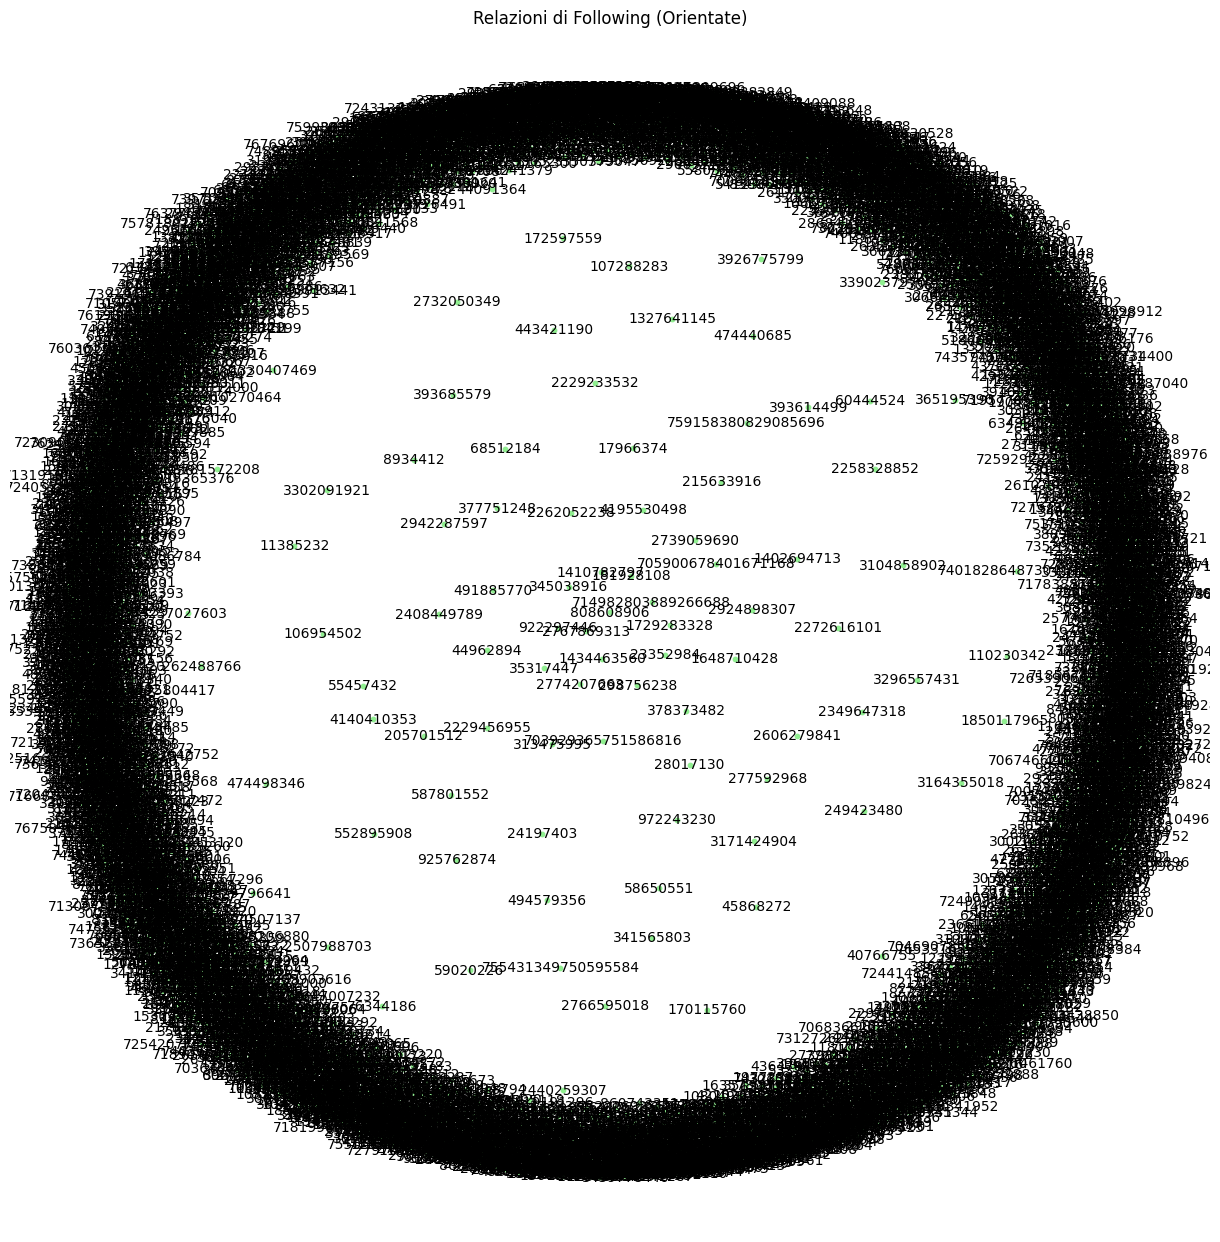

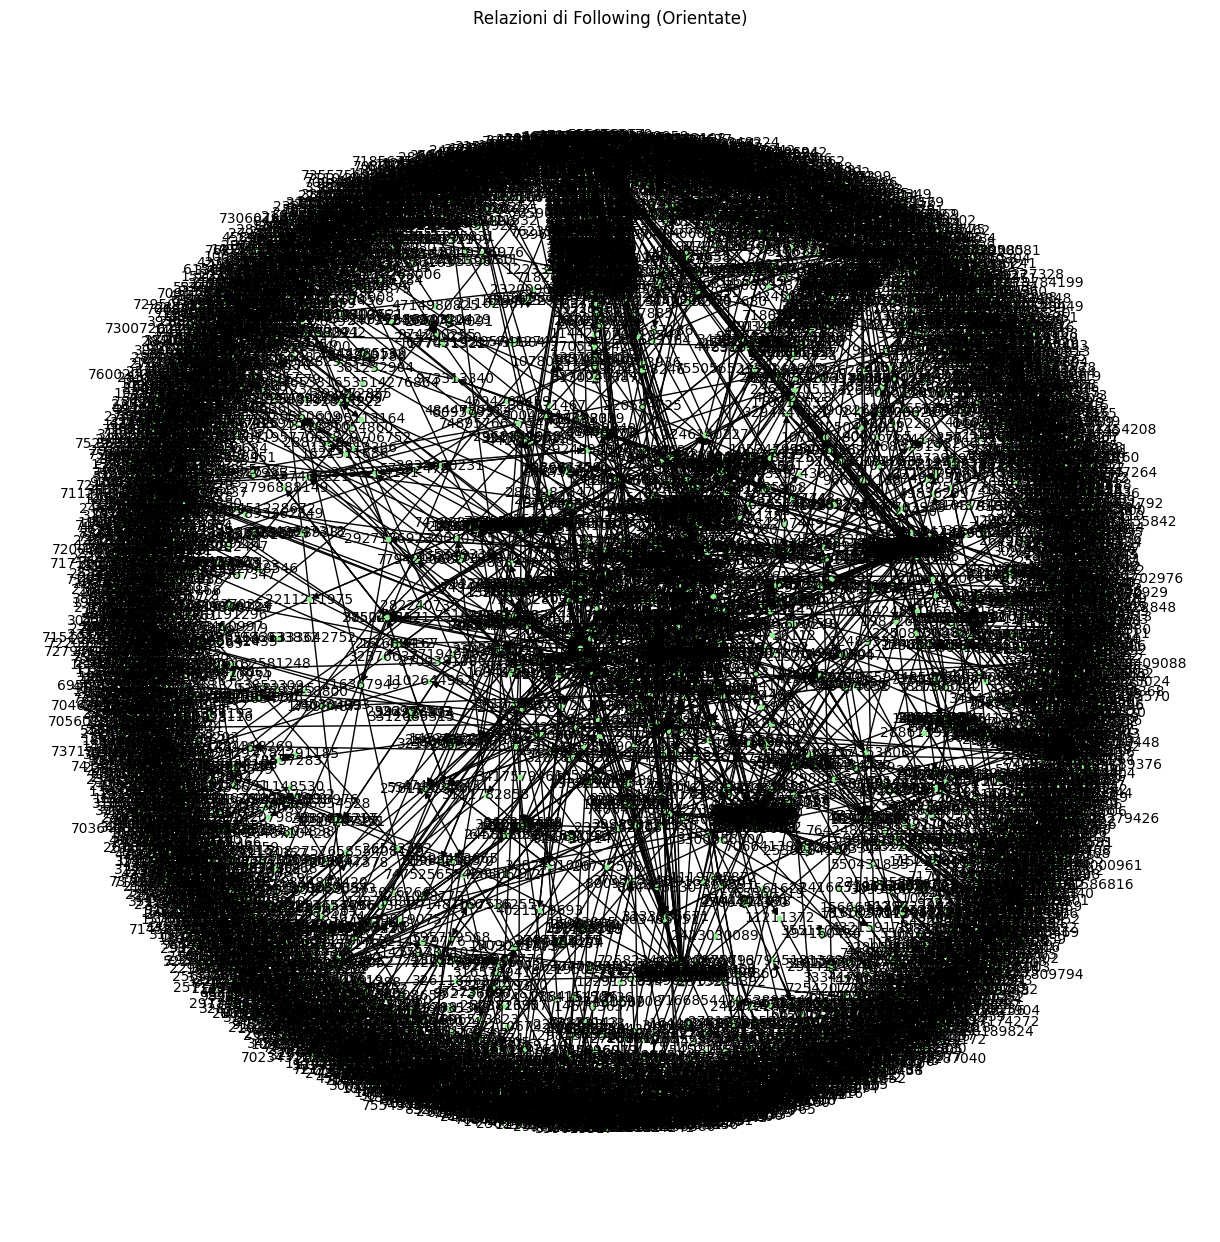

In [37]:
# Visualizzazione dei dati sottoforma di grafo

# Crea un grafo diretto per rappresentare i following
G = nx.DiGraph()

#Aggiunge i nodi al grafo
for _, row in df.iterrows():
    G.add_node(row['id'], friendsCount=row['friendsCount'], followersCount=row['followersCount'], friends=row['friends'], lang=row['lang'], tags=row['tags'])

# Disegna il grafo dei following (orientato) con frecce
plt.figure(figsize=(12, 12))
# Usa il layout spring per posizionare i nodi in modo che le frecce siano visibili
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=10, node_color='lightgreen', font_size=10, font_color='black', arrows=True)

plt.title("Relazioni di Following (Orientate)")
plt.show()

# Aggiunge archi solo se il nodo di destinazione è presente nel dataset (per evitare nodi orfani)
nodes_set = set(df['id'])
for idx, row in df.iterrows():

    source_node = row['id']
    # Lista di amici che saranno effettivamente inclusi
    valid_friends = []

    # Verifica se ogni amico è presente nel dataset
    for friend_id in row['friends']:
        if int(friend_id) in nodes_set:  # Se il nodo di destinazione è presente
            valid_friends.append(friend_id)  # Aggiungi l'amico alla lista valida

    # Aggiorna la lista friends dell'elemento corrente nel dataframe solo con amici validi
    df.at[idx, 'friends'] = valid_friends

    # Aggiungi gli archi per ogni amico valido
    for friend_id in valid_friends:
        friend_row = df[df['id'] == int(friend_id)].squeeze()
        G.add_node(friend_row['id'], friendsCount=friend_row['friendsCount'], friends=friend_row['friends'], lang=friend_row['lang'], tags=row['tags'])
        G.add_edge(source_node, int(friend_id))

# Disegna il grafo dei following (orientato) con frecce
plt.figure(figsize=(12, 12))
# Usa il layout spring per posizionare i nodi in modo che le frecce siano visibili
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=10, node_color='lightgreen', font_size=10, font_color='black', arrows=True)

plt.title("Relazioni di Following (Orientate)")
plt.show()

In [16]:
print("Numero totale dei nodi:", G.number_of_nodes())
print("Numero totale di archi:", G.number_of_edges())

Numero totale dei nodi: 5000
Numero totale di archi: 2785


Coppia con il maggior numero di amici in comune

In [38]:
# Trova la coppia con il maggior numero di amici in comune
most_common_pair, max_common_friends, are_friends = find_most_common_friends(G)

# Stampa il risultato
print(f"La coppia di nodi con il maggior numero di amici in comune è: {most_common_pair}")
print(f"Numero di amici in comune: {max_common_friends}")
print(f"Sono amici tra di loro? {'Sì' if are_friends else 'No'}")


La coppia di nodi con il maggior numero di amici in comune è: (3076725085, 731954451448102912)
Numero di amici in comune: 8
Sono amici tra di loro? Sì


## 3. Graph Centrality analysis
La Graph Centrality Analysis (Analisi della Centralità dei Grafi) è un insieme di tecniche utilizzate per misurare l'importanza o l'influenza di un nodo all'interno di una rete. L'idea di base è che in una rete, alcuni nodi possono essere più centrali rispetto ad altri, in quanto hanno un ruolo chiave nelle comunicazioni, nelle connessioni o nel flusso di informazioni tra gli altri nodi

### Degree Centrality
La degree centrality misura il numero di connessioni dirette (archi) che un nodo ha con altri nodi. Un nodo con un alto grado è considerato importante in termini di connessioni dirette.

In [18]:
#Calcolo della degree centrality
degree_centrality = nx.degree_centrality(G)

# Top 10 users con valore di centralità
top_users_dc = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 users per degree centrality:", top_users_dc)


Top 10 users per degree centrality: [(189283341, 0.046409281856371276), (423723318, 0.021204240848169634), (731954451448102912, 0.012002400480096018), (74231747, 0.008601720344068814), (19772559, 0.008401680336067214), (3076725085, 0.008001600320064013), (29514951, 0.007601520304060812), (4819969125, 0.007401480296059212), (2927212800, 0.007401480296059212), (754838041227845633, 0.007001400280056011)]


### Rilevamento delle comunità
Questo codice esegue il rilevamento delle comunità in un grafo non diretto usando l'algoritmo Louvain, analizza le comunità individuando i nodi centrali in base alla loro centralità di grado, e visualizza un sottografo delle comunità selezionate, colorando i nodi in base alla loro comunità di appartenenza


In [20]:
# Analisi della parte più rilevante di un grafo
# In particolare seleziono i nodi con un grado maggiore di una certa soglia e poi estraggo un sottografo solo con quei nodi
degree_threshold = 3
high_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree > degree_threshold]

H = G.subgraph(high_degree_nodes)

print("Number of nodes:", H.number_of_nodes())
print("Number of edges:", H.number_of_edges())

Number of nodes: 360
Number of edges: 882


Costruzione del grafo indiretto e visualizzazione delle communities

Community 0: 31 nodes, Central Node: 2298043189
Community 1: 47 nodes, Central Node: 731954451448102912
Community 36: 23 nodes, Central Node: 721925849956630528
Community 3: 5 nodes, Central Node: 761981319328870400
Community 4: 28 nodes, Central Node: 1025128844
Community 5: 42 nodes, Central Node: 4819969125
Community 7: 3 nodes, Central Node: 3260744162
Community 16: 25 nodes, Central Node: 29514951
Community 15: 57 nodes, Central Node: 19772559
Community 13: 2 nodes, Central Node: 220821568
Community 17: 3 nodes, Central Node: 1428826266
Community 19: 17 nodes, Central Node: 264470292
Community 22: 2 nodes, Central Node: 1187746027
Community 23: 2 nodes, Central Node: 3207427365
Community 24: 6 nodes, Central Node: 513200857
Community 25: 3 nodes, Central Node: 735742410
Community 27: 11 nodes, Central Node: 370404328
Community 29: 5 nodes, Central Node: 3094168105
Community 33: 2 nodes, Central Node: 1302180632
Community 34: 4 nodes, Central Node: 33234853
Community 37: 2 nodes, C

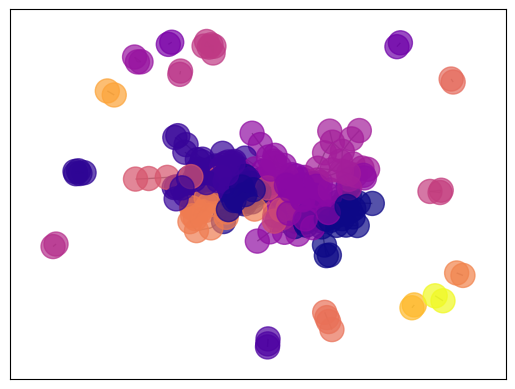

In [21]:
# Da grafo diretto a indiretto
# Converte il grafo diretto H in un grafo indiretto
H_undirect = H.to_undirected()

# Individua le comunità utilizzando l'algoritmo di Louvain
partition = community_louvain.best_partition(H_undirect)

# Raggruppa i nodi in base all'ID della comunità
communities = {}
for node, comm_id in partition.items():
    communities.setdefault(comm_id, []).append(node)

# Inizializza le strutture per la lista delle comunità da visualizzare e altre informazioni
communities_tlist = []
communities_to_display = {}

# Inferenza delle statistiche delle comunità
for comm_id, nodes in communities.items():
    if len(nodes) > 1:  # Considera solo le comunità con più di un nodo
        subgraph = H_undirect.subgraph(nodes)  # Crea il sottografo della comunità
        degree_centrality = nx.degree_centrality(subgraph)  # Calcola la centralità dei gradi
        # Trova il nodo con la massima centralità
        central_node = max(degree_centrality, key=degree_centrality.get)
        print(f"Community {comm_id}: {len(nodes)} nodes, Central Node: {central_node}")
        # Se la comunità ha meno di 500 nodi, aggiungila alla lista delle comunità da visualizzare
        if len(nodes) < 500:
            communities_tlist.append(comm_id)

# Prepara le comunità da visualizzare
for key in communities_tlist:
    communities_to_display[key] = None

# Seleziona i nodi delle comunità da visualizzare
nodes_to_display = [node for node, comm_id in partition.items() if comm_id in communities_to_display]

# Crea il sottografo contenente solo i nodi da visualizzare
subgraph = H_undirect.subgraph(nodes_to_display)

# Calcola il layout per la visualizzazione del grafo
pos = nx.spring_layout(subgraph)
# Scegli la mappa di colori per la visualizzazione
cmap = plt.colormaps['plasma']
# Disegna i nodi del sottografo con colori basati sulle comunità
nx.draw_networkx_nodes(subgraph, pos, node_color=[partition[node] for node in subgraph], cmap=cmap, alpha=0.7)
# Disegna i bordi del sottografo
nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
# Mostra il grafo
plt.show()

### Betweenness centrality
La betweenness centrality è una misura di centralità in un grafo che indica l'importanza di un nodo nel connettere altri nodi all'interno della rete. Un nodo con un'elevata betweenness centrality agisce come un "ponte" o "mediatore" tra altre coppie di nodi, essendo incluso in molti dei percorsi più brevi che collegano due nodi. Viene calcolata contando quante volte un nodo appare lungo i percorsi più brevi tra altri nodi nel grafo. Più alta è la betweenness centrality di un nodo, maggiore è il suo ruolo nel facilitare la comunicazione tra altre parti della rete.

In [22]:
betweenness_scores = nx.betweenness_centrality(H_undirect, k=10, normalized=True, endpoints=False)

# Ordinare i nodi in base al punteggio di betweenness
sorted_betweenness = sorted(betweenness_scores.items(), key=lambda item: item[1], reverse=True)

# Stampare i primi 10 nodi con la centralità più alta
for b in sorted_betweenness[:10]:
    print(f"Node {b[0]}, Centrality: {b[1]}")


Node 791958464, Centrality: 0.18044227666945534
Node 189283341, Centrality: 0.1728719830907223
Node 731954451448102912, Centrality: 0.13591467836908028
Node 4819969125, Centrality: 0.1034436580919754
Node 29514951, Centrality: 0.08571881885799382
Node 4534274352, Centrality: 0.0839977018391983
Node 463577642, Centrality: 0.06727401690776413
Node 3863605355, Centrality: 0.06323724277015122
Node 721925849956630528, Centrality: 0.05967832450769222
Node 2800101466, Centrality: 0.05860891278082862


# 4. Training, evaluation and results
Per la fase di training è stata adattata la rete DGCNN al contesto ricorrendo inoltre ad una riduzione della dimensionalità della matrice di adiacenza per gestire il contesto caratterizzato da migliaia di nodi. La rete ha due scopi di learning:
- Imparare a ricostruire del vettore di features per ciascun nodo
- Imparare a ricostruire la matrice di adiacenza

per cui il valore di loss è in realtà la combinazione di due funzioni di loss, ciascuna per i due obiettivi sopra descritti.


Costruzione dei dizionari per indicizzare tags e friends

In [23]:
# Costruzione di due dizionari contenenti amici e tag
friend_dict = {}  # Dizionario degli amici
tag_dict = {}  # Dizionario dei tag

# Crea una lista di amici unici (tutti gli ID di amici nel grafo)
for node in G.nodes(data=True):
    data = node[1]
    friends = data['friends']
    for friend in friends:
        if friend not in friend_dict:
            friend_dict[friend] = len(friend_dict)

# Crea una lista di tag unici
for node in G.nodes(data=True):
    data = node[1]
    tags = data['tags']
    for tag in tags:
        if tag not in tag_dict:
            tag_dict[tag] = len(tag_dict)

Fase di embedding delle features, costruzione della matrice di adiacenza e suddivisione del dataset in training e test set

In [24]:
# Parametri per gli embedding
embedding_dim = 202  # Dimensione dell'embedding per i tag

# Creazione degli embedding dei tags
tag_embeddings = torch.nn.Embedding(len(tag_dict), embedding_dim)

# Codifica ogni nodo con un vettore che rappresenta i tag
node_features = []

# Lista per la matrice di adiacenza
adjacency_matrix = torch.zeros(len(G.nodes()), len(G.nodes()))

# Tensore per memorizzare le coppie di ID dei nodi (nodo_i, nodo_j) come una matrice bidimensionale
# Il tensore avrà dimensioni (num_nodes, num_nodes, 2) per memorizzare le coppie di ID (nodo_i, friend_id)
adjacency_node_id_matrix = torch.full((len(G.nodes()), len(G.nodes()), 2), 0, dtype=torch.int64)

# Popolamento della matrice di indicizzazione delle coppie di nodi
node_list = list(G.nodes(data=True))
for i in range(len(node_list)):
    for j in range(len(node_list)):
        adjacency_node_id_matrix[i, j] = torch.tensor([node_list[i][0], node_list[j][0]])

# Mappa degli id dei nodi nel grafo
node_idx_map = {node: idx for idx, node in enumerate(G.nodes())}

for i, node in enumerate(G.nodes(data=True)):
    data = node[1]
    lang_code = 0 if data['lang'] == 'en' else 1  # Codifica 'en' come 0, altri come 1

    # Ottieni gli embedding dei tag (media degli embedding)
    tag_indices = [tag_dict[tag] for tag in data['tags'] if tag in tag_dict]
    if tag_indices:
        tag_embedding = tag_embeddings(torch.tensor(tag_indices))
        tag_embedding_mean = tag_embedding.mean(dim=0)
    else:
        tag_embedding_mean = torch.zeros(embedding_dim)

    # Concatenazione delle informazioni
    features = torch.cat([torch.tensor([data['friendsCount']]),
                          torch.tensor([lang_code]),
                          torch.tensor([data['followersCount']]),
                          tag_embedding_mean]).flatten()

    node_features.append(features)

    # Aggiorna la matrice di adiacenza per ogni amico del nodo corrente
    node_id = node[0]
    node_idx = node_idx_map[node_id]
    for friend in data['friends']:
        if friend in node_idx_map:
            friend_idx = node_idx_map[friend]
            adjacency_matrix[node_idx, friend_idx] = 1

# Trasforma la lista di features in un tensore
node_features_tensor = torch.stack(node_features)

# Separa dei nodi in un training set e un validation set (80% training, 20% validation)
num_nodes = len(G.nodes())
train_indices, val_indices = train_test_split(torch.arange(num_nodes), test_size=0.2, random_state=42)
# Estrazione dei dati di addestramento e validazione
train_features = node_features_tensor[train_indices]
val_features = node_features_tensor[val_indices]

# Separa la matrice di adiacenza in due set: training e validation
train_adj_matrix = adjacency_matrix[train_indices][:, train_indices]
val_adj_matrix = adjacency_matrix[val_indices][:, val_indices]

# Separa anche la matrice con le coppie di ID dei nodi
train_adj_node_id_matrix = adjacency_node_id_matrix[train_indices][:, train_indices]
val_adj_node_id_matrix = adjacency_node_id_matrix[val_indices][:, val_indices]

# Output per verificare le dimensioni
print(f"General tensor shape: {node_features_tensor.shape}")
print(f"General adjacency matrix features shape: {adjacency_matrix.shape}")
print(f"General adjacency node id matrix shape: {adjacency_node_id_matrix.shape}")
print(f"Training features shape: {train_features.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"Training adjacency matrix shape: {train_adj_matrix.shape}")
print(f"Validation adjacency matrix shape: {val_adj_matrix.shape}")
print(f"Training adjacency node id matrix shape: {train_adj_node_id_matrix.shape}")
print(f"Validation adjacency node id matrix shape: {val_adj_node_id_matrix.shape}")


General tensor shape: torch.Size([5000, 205])
General adjacency matrix features shape: torch.Size([5000, 5000])
General adjacency node id matrix shape: torch.Size([5000, 5000, 2])
Training features shape: torch.Size([4000, 205])
Validation features shape: torch.Size([1000, 205])
Training adjacency matrix shape: torch.Size([4000, 4000])
Validation adjacency matrix shape: torch.Size([1000, 1000])
Training adjacency node id matrix shape: torch.Size([4000, 4000, 2])
Validation adjacency node id matrix shape: torch.Size([1000, 1000, 2])


In [25]:
# Normalizzazione dei tensori
node_features_tensor_norm = normalize_columns(node_features_tensor)
train_features = normalize_columns(train_features)
val_features = normalize_columns(val_features)

## Definizione della rete e training

Questo modello implementa una rete basata su convoluzioni grafiche per l'elaborazione e la ricostruzione dei dati nei grafi. Le principali componenti includono:

- **Approssimazione a basso rango**: La funzione `low_rank_approximation` stabilizza la matrice di adiacenza tramite regolarizzazione e ne calcola una rappresentazione a basso rango utilizzando la decomposizione SVD.
- **Graph Convolution**: Un layer di convoluzione grafica (`GraphConvolution`) esegue moltiplicazioni matriciali tra la matrice di adiacenza e le caratteristiche dei nodi per propagare le informazioni.
- **Chebynet**: Un'implementazione di reti di convoluzione basate su polinomi di Chebyshev, che utilizza una matrice di adiacenza normalizzata per elaborare i segnali sul grafo.
- **DGCNN con Ricostruzione**: La classe `DGCNN_Reconstruction` combina convoluzioni grafiche con un meccanismo per ricostruire le caratteristiche dei nodi. Essa utilizza:
  - Approssimazioni a basso rango della matrice di adiacenza per ridurre il rumore e il costo computazionale.
  - Una ricostruzione delle caratteristiche latenti e dinamiche per aggiornare la matrice di adiacenza.

L'architettura è progettata per elaborare grafi dinamici, apprendere rappresentazioni latenti e aggiornare iterativamente la struttura del grafo


In [ ]:
# Funzione per l'approssimazione a basso rango
def low_rank_approximation(A, rank):
    """
    Calcola l'approssimazione a basso rango di una matrice A usando la SVD.
    A: la matrice di adiacenza
    rank: il rango desiderato per l'approssimazione
    """
    epsilon = 1e-3
    A_reg = A + epsilon * torch.eye(A.shape[0], device=A.device)  # Stabilizzare la matrice

    try:
        U, S, V = torch.linalg.svd(A_reg, full_matrices=False)  # SVD stabilizzato
    except RuntimeError as e:
        print(f"Errore durante l'SVD: {e}")
        return A  # Se l'SVD fallisce, restituisci la matrice originale

    # Mantiene solo i primi 'rank' valori singolari
    U = U[:, :rank]
    S = S[:rank]
    V = V[:, :rank]

    # Costruisce l'approssimazione a basso rango
    A_approx = torch.matmul(U, torch.matmul(torch.diag(S), V.transpose(0, 1)))

    return A_approx

# Modello
class GraphConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, bias=False):
        super(GraphConvolution, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.weight = nn.Parameter(torch.FloatTensor(in_channels, out_channels))
        nn.init.xavier_normal_(self.weight)
        self.bias = None
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_channels))
            nn.init.zeros_(self.bias)

    def forward(self, x, adj):
        support = torch.matmul(adj, x)  # matmul tra matrice di adiacenza e caratteristiche dei nodi
        output = torch.matmul(support, self.weight)  # moltiplicazione del supporto con il peso

        if self.bias is not None:
            return output + self.bias
        else:
            return output

class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        self.linear = nn.Linear(in_channels, out_channels, bias=bias)
        nn.init.xavier_normal_(self.linear.weight)
        if bias:
            nn.init.zeros_(self.linear.bias)

    def forward(self, inputs):
        return self.linear(inputs)

class Chebynet(nn.Module):
    def __init__(self, in_channels, K, out_channels):
        super(Chebynet, self).__init__()
        self.K = K
        self.gc = nn.ModuleList()
        for i in range(K):
            self.gc.append(GraphConvolution(in_channels, out_channels))

    def forward(self, x, L):
        adj = generate_cheby_adj(L, self.K)
        result = None
        for i, gc_layer in enumerate(self.gc):
            if i == 0:
                result = gc_layer(x, adj[i])  # Passa l'intero tensore x attraverso il layer
            else:
                result += gc_layer(x, adj[i])
        result = F.relu(result)  # Applicare ReLU
        return result

class DGCNN_Reconstruction(nn.Module):
    def __init__(self, in_channels, num_nodes, k_adj, out_channels, dropout_prob=0.5, rank=50):
        super(DGCNN_Reconstruction, self).__init__()
        self.K = k_adj
        self.num_nodes = num_nodes
        self.layer1 = Chebynet(in_channels, k_adj, out_channels)
        self.rank = rank  # Rango per l'approssimazione a basso rango

        # Layers per ricostruire le features
        self.reconstruct_features = nn.Sequential(
            nn.Linear(out_channels, in_channels),
            nn.ReLU()
        )

        # Learnable adjacency matrix
        self.A = nn.Parameter(torch.FloatTensor(num_nodes, num_nodes))
        nn.init.kaiming_normal_(self.A, a=0, mode='fan_in', nonlinearity='relu')
        self.A.data = torch.abs(self.A.data)

    def forward(self, x, batch_indices=None, epoch=None):
        # Normalizzazione della matrice di adiacenza
        if batch_indices is not None:
            L = normalize_A_batch(self.A, batch_indices)  # Normalizza solo per il batch

        # Approssimazione a basso rango della matrice di adiacenza
        L_approx = low_rank_approximation(L, self.rank)  # Approssimazione a basso rango

        # Passa il batch di nodi attraverso i livelli
        latent_features = self.layer1(x, L_approx)

        # Ricostruzione
        reconstructed_features = self.reconstruct_features(latent_features)

        norm_latent_features = F.normalize(latent_features, p=2, dim=-1)  # Normalizza le caratteristiche latenti
        dynamic_adj = F.relu(torch.matmul(norm_latent_features, norm_latent_features.transpose(0, 1)))

        return reconstructed_features, dynamic_adj

def normalize_A_batch(A, batch_indices, lmax=2):
    A = A[batch_indices][:, batch_indices]  # Estrae i nodi del batch
    A = F.relu(A)
    N = A.shape[0]
    A = A * (torch.ones(N, N, device=A.device) - torch.eye(N, N, device=A.device))
    A = A + A.T
    d = torch.sum(A, 1)
    d = 1 / torch.sqrt((d + 1e-10))
    D = torch.diag(d)
    L = torch.eye(N, N, device=A.device) - torch.matmul(torch.matmul(D, A), D)
    Lnorm = (2 * L / lmax) - torch.eye(N, N, device=A.device)
    return Lnorm

def generate_cheby_adj(L, K):
    support = []
    for i in range(K):
        if i == 0:
            support.append(torch.eye(L.shape[-1], device=L.device))
        elif i == 1:
            support.append(L)
        else:
            temp = torch.matmul(2 * L, support[-1]) - support[-2]
            support.append(temp)
    return support

# Sposta il modello e i dati su GPU (se disponibile)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Esempio di inizializzazione e spostamento su GPU
num_nodes = 100
in_channels = 16
out_channels = 32
k_adj = 3
rank = 50

model = DGCNN_Reconstruction(in_channels, num_nodes, k_adj, out_channels, rank=rank).to(device)
input_features = torch.randn(num_nodes, in_channels).to(device)
batch_indices = torch.arange(num_nodes).to(device)

# Esempio di forward
reconstructed_features, dynamic_adj = model(input_features, batch_indices)


Ciclo di allenamento

In [33]:
# Definizione del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_nodes = train_features.size(0)
in_channels = train_features.size(1)
out_channels = 50  # Numero di canali di uscita
k_adj = 3  # Numero di polinomi di Chebyshev
epochs = 500 # Numero di epoche per l'allenamento

# Spostamento dei dati su GPU
train_features = train_features.to(device)
train_adj_matrix = train_adj_matrix.to(device)
val_features = val_features.to(device)
val_adj_matrix = val_adj_matrix.to(device)

# Inizializzazione della rete DGCNN
model = DGCNN_Reconstruction(in_channels, num_nodes, k_adj, out_channels).to(device)

# Funzione di perdita (errore quadratico medio per la ricostruzione)
criterionRec = nn.SmoothL1Loss().to(device)
criterionAdj = nn.BCEWithLogitsLoss().to(device)

# Ottimizzatore
optimizer = AdamW(model.parameters(), lr=0.0005)

# Variabili per monitorare la validazione
best_val_value = 0
best_epoch = 0
best_model_path = 'best_model.pth'

# Variabili per memorizzare la matrice di adiacenza
best_val_adj_matrix = None

# Inizializzazione della matrice di adiacenza per il training set
train_count = int((train_adj_matrix == 1).sum().item())

# Ciclo di allenamento
for epoch in tqdm(range(epochs), desc="Epoch Progress"):
    loss, adj_matrix_model = train_batch(model, optimizer, criterionRec, criterionAdj, train_features, train_adj_matrix, batch_size=512, num_nodes=num_nodes)

    # Salva la matrice di adiacenza finale ogni 5 epoche
    if epoch % 5 == 0:
        final_adj_matrix = adj_matrix_model.cpu().detach().numpy()

    # Valutazione sul training
    adj_matrix_binary = threshold_adjacency_matrix(adj_matrix_model, 0.5)
    train_value, _, _, _, _, _ = confronta_matrici(adj_matrix_binary, train_adj_matrix)

    # Log dei risultati
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}, Training number: {int(train_value)}/{train_count}")

    # Validazione ogni 5 epoche
    if (epoch + 1) % 5 == 0:
        val_loss, val_adj_matrix_model = validate(model, criterionRec, criterionAdj, val_features, val_adj_matrix, batch_size=512, num_nodes=val_features.size(0))

        # Valutazione sulla validazione
        val_adj_matrix_binary = threshold_adjacency_matrix(val_adj_matrix_model, 0.5)
        val_value, _, _, _, _, _ = confronta_matrici(val_adj_matrix_binary, val_adj_matrix)

        print(f"Validation Epoch {epoch + 1}/{epochs}, Val Loss: {val_loss}, Validation number: {val_value}/{int(val_adj_matrix.sum().item())}")

        # Salva il modello e la matrice di adiacenza se il numero di elementi predetti correttamente è migliorato
        if val_value > best_val_value:
            best_val_value = val_value
            best_epoch = epoch + 1

            # Salva il modello
            torch.save(model.state_dict(), best_model_path)
            # Salva la matrice di adiacenza
            best_val_adj_matrix = val_adj_matrix_model.cpu().detach()
            print(f'Modello salvato alla epoca {best_epoch}.')


Epoch Progress:   0%|          | 1/500 [00:02<22:26,  2.70s/it]

Epoch 1/500, Loss: 1.0777288377285004, Training number: 196/1860



Epoch Progress:   0%|          | 2/500 [00:05<21:56,  2.64s/it]

Epoch 2/500, Loss: 1.0721455216407776, Training number: 183/1860



Epoch Progress:   1%|          | 3/500 [00:07<21:37,  2.61s/it]

Epoch 3/500, Loss: 1.07211235165596, Training number: 184/1860



Epoch Progress:   1%|          | 4/500 [00:10<21:23,  2.59s/it]

Epoch 4/500, Loss: 1.0743796229362488, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


Epoch 5/500, Loss: 1.0751224160194397, Training number: 191/1860



Validation Batch Progress: 100%|██████████| 2/2 [00:00<00:00, 25.92it/s]


Validation Epoch 5/500, Val Loss: 1.083939254283905, Validation number: 31.0/85


Epoch Progress:   1%|          | 5/500 [00:13<22:02,  2.67s/it]

Modello salvato alla epoca 5.



Epoch Progress:   1%|          | 6/500 [00:15<21:57,  2.67s/it]

Epoch 6/500, Loss: 1.0751293450593948, Training number: 191/1860



Epoch Progress:   1%|▏         | 7/500 [00:18<21:41,  2.64s/it]

Epoch 7/500, Loss: 1.0723721235990524, Training number: 191/1860



Epoch Progress:   2%|▏         | 8/500 [00:21<21:30,  2.62s/it]

Epoch 8/500, Loss: 1.0722661316394806, Training number: 191/1860



Epoch Progress:   2%|▏         | 9/500 [00:23<21:19,  2.61s/it]

Epoch 9/500, Loss: 1.0724138915538788, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Epoch 10/500, Loss: 1.072057083249092, Training number: 191/1860



Epoch Progress:   2%|▏         | 10/500 [00:26<21:29,  2.63s/it]

Validation Epoch 10/500, Val Loss: 1.0791679620742798, Validation number: 31.0/85



Epoch Progress:   2%|▏         | 11/500 [00:28<21:30,  2.64s/it]

Epoch 11/500, Loss: 1.0717777609825134, Training number: 191/1860



Epoch Progress:   2%|▏         | 12/500 [00:31<21:19,  2.62s/it]

Epoch 12/500, Loss: 1.071760132908821, Training number: 191/1860



Epoch Progress:   3%|▎         | 13/500 [00:34<21:18,  2.62s/it]

Epoch 13/500, Loss: 1.0714916437864304, Training number: 191/1860



Epoch Progress:   3%|▎         | 14/500 [00:36<21:13,  2.62s/it]

Epoch 14/500, Loss: 1.0716899782419205, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


Epoch 15/500, Loss: 1.0716780871152878, Training number: 191/1860



Epoch Progress:   3%|▎         | 15/500 [00:39<21:24,  2.65s/it]

Validation Epoch 15/500, Val Loss: 1.0762805342674255, Validation number: 31.0/85



Epoch Progress:   3%|▎         | 16/500 [00:42<21:17,  2.64s/it]

Epoch 16/500, Loss: 1.0716601759195328, Training number: 191/1860



Epoch Progress:   3%|▎         | 17/500 [00:44<21:05,  2.62s/it]

Epoch 17/500, Loss: 1.0716487169265747, Training number: 191/1860



Epoch Progress:   4%|▎         | 18/500 [00:47<20:57,  2.61s/it]

Epoch 18/500, Loss: 1.0714602917432785, Training number: 191/1860



Epoch Progress:   4%|▍         | 19/500 [00:49<20:53,  2.61s/it]

Epoch 19/500, Loss: 1.0711301267147064, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


Epoch 20/500, Loss: 1.071448341012001, Training number: 191/1860



Epoch Progress:   4%|▍         | 20/500 [00:52<21:06,  2.64s/it]

Validation Epoch 20/500, Val Loss: 1.0759889483451843, Validation number: 31.0/85



Epoch Progress:   4%|▍         | 21/500 [00:55<21:02,  2.64s/it]

Epoch 21/500, Loss: 1.0714240819215775, Training number: 191/1860



Epoch Progress:   4%|▍         | 22/500 [00:57<20:54,  2.63s/it]

Epoch 22/500, Loss: 1.0714429765939713, Training number: 191/1860



Epoch Progress:   5%|▍         | 23/500 [01:00<20:49,  2.62s/it]

Epoch 23/500, Loss: 1.0711270421743393, Training number: 191/1860



Epoch Progress:   5%|▍         | 24/500 [01:03<20:53,  2.63s/it]

Epoch 24/500, Loss: 1.0713741183280945, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Epoch 25/500, Loss: 1.0711845308542252, Training number: 191/1860



Epoch Progress:   5%|▌         | 25/500 [01:05<20:59,  2.65s/it]

Validation Epoch 25/500, Val Loss: 1.0750084519386292, Validation number: 30.0/85



Epoch Progress:   5%|▌         | 26/500 [01:08<20:49,  2.64s/it]

Epoch 26/500, Loss: 1.0711647421121597, Training number: 191/1860



Epoch Progress:   5%|▌         | 27/500 [01:11<20:43,  2.63s/it]

Epoch 27/500, Loss: 1.0711761265993118, Training number: 191/1860



Epoch Progress:   6%|▌         | 28/500 [01:13<20:34,  2.62s/it]

Epoch 28/500, Loss: 1.0711916536092758, Training number: 191/1860



Epoch Progress:   6%|▌         | 29/500 [01:16<20:29,  2.61s/it]

Epoch 29/500, Loss: 1.0707565993070602, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


Epoch 30/500, Loss: 1.0705661326646805, Training number: 191/1860



Epoch Progress:   6%|▌         | 30/500 [01:18<20:39,  2.64s/it]

Validation Epoch 30/500, Val Loss: 1.0738476514816284, Validation number: 30.0/85



Epoch Progress:   6%|▌         | 31/500 [01:21<20:33,  2.63s/it]

Epoch 31/500, Loss: 1.0700844526290894, Training number: 191/1860



Epoch Progress:   6%|▋         | 32/500 [01:24<20:26,  2.62s/it]

Epoch 32/500, Loss: 1.0700630843639374, Training number: 191/1860



Epoch Progress:   7%|▋         | 33/500 [01:26<20:18,  2.61s/it]

Epoch 33/500, Loss: 1.0699140578508377, Training number: 191/1860



Epoch Progress:   7%|▋         | 34/500 [01:29<20:13,  2.60s/it]

Epoch 34/500, Loss: 1.0692791044712067, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Epoch 35/500, Loss: 1.0689177513122559, Training number: 191/1860



Epoch Progress:   7%|▋         | 35/500 [01:31<20:21,  2.63s/it]

Validation Epoch 35/500, Val Loss: 1.0732142925262451, Validation number: 31.0/85



Epoch Progress:   7%|▋         | 36/500 [01:34<20:14,  2.62s/it]

Epoch 36/500, Loss: 1.068774327635765, Training number: 191/1860



Epoch Progress:   7%|▋         | 37/500 [01:37<20:08,  2.61s/it]

Epoch 37/500, Loss: 1.0686865001916885, Training number: 191/1860



Epoch Progress:   8%|▊         | 38/500 [01:39<20:03,  2.61s/it]

Epoch 38/500, Loss: 1.0681086033582687, Training number: 191/1860



Epoch Progress:   8%|▊         | 39/500 [01:42<19:59,  2.60s/it]

Epoch 39/500, Loss: 1.06851826608181, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


Epoch 40/500, Loss: 1.0679720342159271, Training number: 191/1860



Epoch Progress:   8%|▊         | 40/500 [01:45<20:05,  2.62s/it]

Validation Epoch 40/500, Val Loss: 1.0733490586280823, Validation number: 31.0/85



Epoch Progress:   8%|▊         | 41/500 [01:47<19:57,  2.61s/it]

Epoch 41/500, Loss: 1.0679802149534225, Training number: 191/1860



Epoch Progress:   8%|▊         | 42/500 [01:50<19:54,  2.61s/it]

Epoch 42/500, Loss: 1.0678239911794662, Training number: 191/1860



Epoch Progress:   9%|▊         | 43/500 [01:52<19:48,  2.60s/it]

Epoch 43/500, Loss: 1.06760835647583, Training number: 191/1860



Epoch Progress:   9%|▉         | 44/500 [01:55<19:50,  2.61s/it]

Epoch 44/500, Loss: 1.067611187696457, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


Epoch 45/500, Loss: 1.067633032798767, Training number: 191/1860



Epoch Progress:   9%|▉         | 45/500 [01:58<19:53,  2.62s/it]

Validation Epoch 45/500, Val Loss: 1.0733706951141357, Validation number: 31.0/85



Epoch Progress:   9%|▉         | 46/500 [02:00<19:47,  2.61s/it]

Epoch 46/500, Loss: 1.06765778362751, Training number: 191/1860



Epoch Progress:   9%|▉         | 47/500 [02:03<19:49,  2.63s/it]

Epoch 47/500, Loss: 1.067683607339859, Training number: 191/1860



Epoch Progress:  10%|▉         | 48/500 [02:05<19:46,  2.63s/it]

Epoch 48/500, Loss: 1.067684143781662, Training number: 191/1860



Epoch Progress:  10%|▉         | 49/500 [02:08<19:41,  2.62s/it]

Epoch 49/500, Loss: 1.0676709711551666, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Epoch 50/500, Loss: 1.067676618695259, Training number: 191/1860



Epoch Progress:  10%|█         | 50/500 [02:11<19:45,  2.64s/it]

Validation Epoch 50/500, Val Loss: 1.073310136795044, Validation number: 31.0/85



Epoch Progress:  10%|█         | 51/500 [02:13<19:40,  2.63s/it]

Epoch 51/500, Loss: 1.0676695704460144, Training number: 191/1860



Epoch Progress:  10%|█         | 52/500 [02:16<19:35,  2.62s/it]

Epoch 52/500, Loss: 1.0676570981740952, Training number: 191/1860



Epoch Progress:  11%|█         | 53/500 [02:19<19:29,  2.62s/it]

Epoch 53/500, Loss: 1.067667230963707, Training number: 191/1860



Epoch Progress:  11%|█         | 54/500 [02:21<19:20,  2.60s/it]

Epoch 54/500, Loss: 1.0676548182964325, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Epoch 55/500, Loss: 1.0676452815532684, Training number: 191/1860



Epoch Progress:  11%|█         | 55/500 [02:24<19:26,  2.62s/it]

Validation Epoch 55/500, Val Loss: 1.073291838169098, Validation number: 31.0/85



Epoch Progress:  11%|█         | 56/500 [02:26<19:19,  2.61s/it]

Epoch 56/500, Loss: 1.0676427334547043, Training number: 191/1860



Epoch Progress:  11%|█▏        | 57/500 [02:29<19:12,  2.60s/it]

Epoch 57/500, Loss: 1.067642703652382, Training number: 191/1860



Epoch Progress:  12%|█▏        | 58/500 [02:32<19:08,  2.60s/it]

Epoch 58/500, Loss: 1.0676270872354507, Training number: 191/1860



Epoch Progress:  12%|█▏        | 59/500 [02:34<19:05,  2.60s/it]

Epoch 59/500, Loss: 1.0676068812608719, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


Epoch 60/500, Loss: 1.0675884932279587, Training number: 191/1860



Epoch Progress:  12%|█▏        | 60/500 [02:37<19:18,  2.63s/it]

Validation Epoch 60/500, Val Loss: 1.0722872614860535, Validation number: 31.0/85



Epoch Progress:  12%|█▏        | 61/500 [02:39<19:11,  2.62s/it]

Epoch 61/500, Loss: 1.0675550401210785, Training number: 191/1860



Epoch Progress:  12%|█▏        | 62/500 [02:42<19:09,  2.62s/it]

Epoch 62/500, Loss: 1.0675657093524933, Training number: 191/1860



Epoch Progress:  13%|█▎        | 63/500 [02:45<19:04,  2.62s/it]

Epoch 63/500, Loss: 1.0666103810071945, Training number: 191/1860



Epoch Progress:  13%|█▎        | 64/500 [02:47<18:58,  2.61s/it]

Epoch 64/500, Loss: 1.0664659142494202, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 65/500, Loss: 1.0662808865308762, Training number: 191/1860



Epoch Progress:  13%|█▎        | 65/500 [02:50<19:03,  2.63s/it]

Validation Epoch 65/500, Val Loss: 1.0722802877426147, Validation number: 31.0/85



Epoch Progress:  13%|█▎        | 66/500 [02:53<18:59,  2.63s/it]

Epoch 66/500, Loss: 1.0659364610910416, Training number: 191/1860



Epoch Progress:  13%|█▎        | 67/500 [02:55<18:58,  2.63s/it]

Epoch 67/500, Loss: 1.0656389892101288, Training number: 191/1860



Epoch Progress:  14%|█▎        | 68/500 [02:58<18:54,  2.63s/it]

Epoch 68/500, Loss: 1.0656519681215286, Training number: 191/1860



Epoch Progress:  14%|█▍        | 69/500 [03:00<18:45,  2.61s/it]

Epoch 69/500, Loss: 1.065790444612503, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


Epoch 70/500, Loss: 1.065893217921257, Training number: 191/1860



Epoch Progress:  14%|█▍        | 70/500 [03:03<18:59,  2.65s/it]

Validation Epoch 70/500, Val Loss: 1.0722463726997375, Validation number: 31.0/85



Epoch Progress:  14%|█▍        | 71/500 [03:06<18:49,  2.63s/it]

Epoch 71/500, Loss: 1.0657244622707367, Training number: 191/1860



Epoch Progress:  14%|█▍        | 72/500 [03:08<18:42,  2.62s/it]

Epoch 72/500, Loss: 1.0671664029359818, Training number: 191/1860



Epoch Progress:  15%|█▍        | 73/500 [03:11<18:36,  2.61s/it]

Epoch 73/500, Loss: 1.0674386024475098, Training number: 191/1860



Epoch Progress:  15%|█▍        | 74/500 [03:14<18:33,  2.61s/it]

Epoch 74/500, Loss: 1.0659071505069733, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Epoch 75/500, Loss: 1.065895140171051, Training number: 191/1860



Epoch Progress:  15%|█▌        | 75/500 [03:16<18:41,  2.64s/it]

Validation Epoch 75/500, Val Loss: 1.072175681591034, Validation number: 31.0/85



Epoch Progress:  15%|█▌        | 76/500 [03:19<18:38,  2.64s/it]

Epoch 76/500, Loss: 1.0658297091722488, Training number: 191/1860



Epoch Progress:  15%|█▌        | 77/500 [03:21<18:32,  2.63s/it]

Epoch 77/500, Loss: 1.0655883699655533, Training number: 191/1860



Epoch Progress:  16%|█▌        | 78/500 [03:24<18:28,  2.63s/it]

Epoch 78/500, Loss: 1.0655781030654907, Training number: 191/1860



Epoch Progress:  16%|█▌        | 79/500 [03:27<18:24,  2.62s/it]

Epoch 79/500, Loss: 1.065605252981186, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Epoch 80/500, Loss: 1.0655880570411682, Training number: 191/1860



Epoch Progress:  16%|█▌        | 80/500 [03:29<18:28,  2.64s/it]

Validation Epoch 80/500, Val Loss: 1.072157084941864, Validation number: 31.0/85



Epoch Progress:  16%|█▌        | 81/500 [03:32<18:26,  2.64s/it]

Epoch 81/500, Loss: 1.065576195716858, Training number: 191/1860



Epoch Progress:  16%|█▋        | 82/500 [03:35<18:15,  2.62s/it]

Epoch 82/500, Loss: 1.065575197339058, Training number: 191/1860



Epoch Progress:  17%|█▋        | 83/500 [03:37<18:12,  2.62s/it]

Epoch 83/500, Loss: 1.065572053194046, Training number: 191/1860



Epoch Progress:  17%|█▋        | 84/500 [03:40<18:03,  2.60s/it]

Epoch 84/500, Loss: 1.0655720829963684, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Epoch 85/500, Loss: 1.065557599067688, Training number: 191/1860



Epoch Progress:  17%|█▋        | 85/500 [03:42<18:08,  2.62s/it]

Validation Epoch 85/500, Val Loss: 1.0721505880355835, Validation number: 31.0/85



Epoch Progress:  17%|█▋        | 86/500 [03:45<18:08,  2.63s/it]

Epoch 86/500, Loss: 1.0655534863471985, Training number: 191/1860



Epoch Progress:  17%|█▋        | 87/500 [03:48<18:02,  2.62s/it]

Epoch 87/500, Loss: 1.0655545145273209, Training number: 191/1860



Epoch Progress:  18%|█▊        | 88/500 [03:50<17:54,  2.61s/it]

Epoch 88/500, Loss: 1.0655678361654282, Training number: 191/1860



Epoch Progress:  18%|█▊        | 89/500 [03:53<17:50,  2.61s/it]

Epoch 89/500, Loss: 1.0655573904514313, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 90/500, Loss: 1.0655615478754044, Training number: 191/1860



Epoch Progress:  18%|█▊        | 90/500 [03:56<17:57,  2.63s/it]

Validation Epoch 90/500, Val Loss: 1.072141170501709, Validation number: 31.0/85



Epoch Progress:  18%|█▊        | 91/500 [03:58<17:55,  2.63s/it]

Epoch 91/500, Loss: 1.0655553489923477, Training number: 191/1860



Epoch Progress:  18%|█▊        | 92/500 [04:01<17:46,  2.61s/it]

Epoch 92/500, Loss: 1.065559834241867, Training number: 191/1860



Epoch Progress:  19%|█▊        | 93/500 [04:03<17:41,  2.61s/it]

Epoch 93/500, Loss: 1.0655598044395447, Training number: 191/1860



Epoch Progress:  19%|█▉        | 94/500 [04:06<17:44,  2.62s/it]

Epoch 94/500, Loss: 1.065546229481697, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


Epoch 95/500, Loss: 1.0655561983585358, Training number: 191/1860



Epoch Progress:  19%|█▉        | 95/500 [04:09<17:51,  2.65s/it]

Validation Epoch 95/500, Val Loss: 1.072142243385315, Validation number: 31.0/85



Epoch Progress:  19%|█▉        | 96/500 [04:11<17:50,  2.65s/it]

Epoch 96/500, Loss: 1.065549299120903, Training number: 191/1860



Epoch Progress:  19%|█▉        | 97/500 [04:14<17:40,  2.63s/it]

Epoch 97/500, Loss: 1.0655471980571747, Training number: 191/1860



Epoch Progress:  20%|█▉        | 98/500 [04:17<17:33,  2.62s/it]

Epoch 98/500, Loss: 1.0655522048473358, Training number: 191/1860



Epoch Progress:  20%|█▉        | 99/500 [04:19<17:27,  2.61s/it]

Epoch 99/500, Loss: 1.0655522048473358, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


Epoch 100/500, Loss: 1.0655516684055328, Training number: 191/1860



Epoch Progress:  20%|██        | 100/500 [04:22<17:35,  2.64s/it]

Validation Epoch 100/500, Val Loss: 1.0721387267112732, Validation number: 31.0/85



Epoch Progress:  20%|██        | 101/500 [04:24<17:26,  2.62s/it]

Epoch 101/500, Loss: 1.0655539631843567, Training number: 191/1860



Epoch Progress:  20%|██        | 102/500 [04:27<17:20,  2.61s/it]

Epoch 102/500, Loss: 1.065554291009903, Training number: 191/1860



Epoch Progress:  21%|██        | 103/500 [04:30<17:14,  2.61s/it]

Epoch 103/500, Loss: 1.0655471831560135, Training number: 191/1860



Epoch Progress:  21%|██        | 104/500 [04:32<17:13,  2.61s/it]

Epoch 104/500, Loss: 1.0655549764633179, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 105/500, Loss: 1.0655563324689865, Training number: 191/1860



Epoch Progress:  21%|██        | 105/500 [04:35<17:18,  2.63s/it]

Validation Epoch 105/500, Val Loss: 1.0721423029899597, Validation number: 31.0/85



Epoch Progress:  21%|██        | 106/500 [04:38<17:16,  2.63s/it]

Epoch 106/500, Loss: 1.065551534295082, Training number: 191/1860



Epoch Progress:  21%|██▏       | 107/500 [04:40<17:09,  2.62s/it]

Epoch 107/500, Loss: 1.0655536353588104, Training number: 191/1860



Epoch Progress:  22%|██▏       | 108/500 [04:43<17:03,  2.61s/it]

Epoch 108/500, Loss: 1.0655539780855179, Training number: 191/1860



Epoch Progress:  22%|██▏       | 109/500 [04:45<16:58,  2.60s/it]

Epoch 109/500, Loss: 1.065552294254303, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Epoch 110/500, Loss: 1.065545067191124, Training number: 191/1860



Epoch Progress:  22%|██▏       | 110/500 [04:48<17:06,  2.63s/it]

Validation Epoch 110/500, Val Loss: 1.0721386075019836, Validation number: 31.0/85



Epoch Progress:  22%|██▏       | 111/500 [04:51<16:59,  2.62s/it]

Epoch 111/500, Loss: 1.0655518472194672, Training number: 191/1860



Epoch Progress:  22%|██▏       | 112/500 [04:53<16:53,  2.61s/it]

Epoch 112/500, Loss: 1.0655454844236374, Training number: 191/1860



Epoch Progress:  23%|██▎       | 113/500 [04:56<16:47,  2.60s/it]

Epoch 113/500, Loss: 1.0655484348535538, Training number: 191/1860



Epoch Progress:  23%|██▎       | 114/500 [04:58<16:43,  2.60s/it]

Epoch 114/500, Loss: 1.0655468702316284, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Epoch 115/500, Loss: 1.0655497461557388, Training number: 191/1860



Epoch Progress:  23%|██▎       | 115/500 [05:01<16:48,  2.62s/it]

Validation Epoch 115/500, Val Loss: 1.072157859802246, Validation number: 31.0/85



Epoch Progress:  23%|██▎       | 116/500 [05:04<16:45,  2.62s/it]

Epoch 116/500, Loss: 1.0655482560396194, Training number: 191/1860



Epoch Progress:  23%|██▎       | 117/500 [05:06<16:43,  2.62s/it]

Epoch 117/500, Loss: 1.0655505806207657, Training number: 191/1860



Epoch Progress:  24%|██▎       | 118/500 [05:09<16:36,  2.61s/it]

Epoch 118/500, Loss: 1.0656617879867554, Training number: 191/1860



Epoch Progress:  24%|██▍       | 119/500 [05:11<16:32,  2.61s/it]

Epoch 119/500, Loss: 1.065553456544876, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


Epoch 120/500, Loss: 1.0655459761619568, Training number: 191/1860



Epoch Progress:  24%|██▍       | 120/500 [05:14<16:35,  2.62s/it]

Validation Epoch 120/500, Val Loss: 1.0721585750579834, Validation number: 31.0/85



Epoch Progress:  24%|██▍       | 121/500 [05:17<16:27,  2.61s/it]

Epoch 121/500, Loss: 1.0658261328935623, Training number: 191/1860



Epoch Progress:  24%|██▍       | 122/500 [05:19<16:20,  2.59s/it]

Epoch 122/500, Loss: 1.0656200349330902, Training number: 191/1860



Epoch Progress:  25%|██▍       | 123/500 [05:22<16:22,  2.61s/it]

Epoch 123/500, Loss: 1.06564162671566, Training number: 191/1860



Epoch Progress:  25%|██▍       | 124/500 [05:24<16:18,  2.60s/it]

Epoch 124/500, Loss: 1.0655699968338013, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


Epoch 125/500, Loss: 1.065555915236473, Training number: 191/1860



Epoch Progress:  25%|██▌       | 125/500 [05:27<16:22,  2.62s/it]

Validation Epoch 125/500, Val Loss: 1.0721481442451477, Validation number: 31.0/85



Epoch Progress:  25%|██▌       | 126/500 [05:30<16:18,  2.62s/it]

Epoch 126/500, Loss: 1.0657905042171478, Training number: 191/1860



Epoch Progress:  25%|██▌       | 127/500 [05:32<16:14,  2.61s/it]

Epoch 127/500, Loss: 1.0658402293920517, Training number: 191/1860



Epoch Progress:  26%|██▌       | 128/500 [05:35<16:11,  2.61s/it]

Epoch 128/500, Loss: 1.0656126737594604, Training number: 191/1860



Epoch Progress:  26%|██▌       | 129/500 [05:38<16:11,  2.62s/it]

Epoch 129/500, Loss: 1.065554901957512, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 130/500, Loss: 1.0655655264854431, Training number: 191/1860



Epoch Progress:  26%|██▌       | 130/500 [05:40<16:15,  2.64s/it]

Validation Epoch 130/500, Val Loss: 1.0721489787101746, Validation number: 31.0/85



Epoch Progress:  26%|██▌       | 131/500 [05:43<16:07,  2.62s/it]

Epoch 131/500, Loss: 1.0655543357133865, Training number: 191/1860



Epoch Progress:  26%|██▋       | 132/500 [05:45<16:01,  2.61s/it]

Epoch 132/500, Loss: 1.065579667687416, Training number: 191/1860



Epoch Progress:  27%|██▋       | 133/500 [05:48<15:58,  2.61s/it]

Epoch 133/500, Loss: 1.065828263759613, Training number: 191/1860



Epoch Progress:  27%|██▋       | 134/500 [05:51<15:52,  2.60s/it]

Epoch 134/500, Loss: 1.065889596939087, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 135/500, Loss: 1.0660704523324966, Training number: 191/1860



Epoch Progress:  27%|██▋       | 135/500 [05:53<15:57,  2.62s/it]

Validation Epoch 135/500, Val Loss: 1.0722335577011108, Validation number: 31.0/85



Epoch Progress:  27%|██▋       | 136/500 [05:56<15:49,  2.61s/it]

Epoch 136/500, Loss: 1.0660922676324844, Training number: 191/1860



Epoch Progress:  27%|██▋       | 137/500 [05:59<15:46,  2.61s/it]

Epoch 137/500, Loss: 1.0662842094898224, Training number: 191/1860



Epoch Progress:  28%|██▊       | 138/500 [06:01<15:41,  2.60s/it]

Epoch 138/500, Loss: 1.066425859928131, Training number: 191/1860



Epoch Progress:  28%|██▊       | 139/500 [06:04<15:38,  2.60s/it]

Epoch 139/500, Loss: 1.0664626061916351, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Epoch 140/500, Loss: 1.0663194209337234, Training number: 191/1860



Epoch Progress:  28%|██▊       | 140/500 [06:06<15:45,  2.63s/it]

Validation Epoch 140/500, Val Loss: 1.0726122856140137, Validation number: 31.0/85



Epoch Progress:  28%|██▊       | 141/500 [06:09<15:46,  2.64s/it]

Epoch 141/500, Loss: 1.066114142537117, Training number: 191/1860



Epoch Progress:  28%|██▊       | 142/500 [06:12<15:41,  2.63s/it]

Epoch 142/500, Loss: 1.066250041127205, Training number: 191/1860



Epoch Progress:  29%|██▊       | 143/500 [06:14<15:33,  2.61s/it]

Epoch 143/500, Loss: 1.0661207884550095, Training number: 191/1860



Epoch Progress:  29%|██▉       | 144/500 [06:17<15:28,  2.61s/it]

Epoch 144/500, Loss: 1.0664317905902863, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 145/500, Loss: 1.0664508044719696, Training number: 191/1860



Epoch Progress:  29%|██▉       | 145/500 [06:20<15:33,  2.63s/it]

Validation Epoch 145/500, Val Loss: 1.0724176168441772, Validation number: 31.0/85



Epoch Progress:  29%|██▉       | 146/500 [06:22<15:27,  2.62s/it]

Epoch 146/500, Loss: 1.0663660019636154, Training number: 191/1860



Epoch Progress:  29%|██▉       | 147/500 [06:25<15:24,  2.62s/it]

Epoch 147/500, Loss: 1.0661157071590424, Training number: 191/1860



Epoch Progress:  30%|██▉       | 148/500 [06:27<15:19,  2.61s/it]

Epoch 148/500, Loss: 1.0662324279546738, Training number: 191/1860



Epoch Progress:  30%|██▉       | 149/500 [06:30<15:14,  2.61s/it]

Epoch 149/500, Loss: 1.0661366283893585, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 150/500, Loss: 1.0661160498857498, Training number: 191/1860



Epoch Progress:  30%|███       | 150/500 [06:33<15:18,  2.63s/it]

Validation Epoch 150/500, Val Loss: 1.0726293921470642, Validation number: 31.0/85



Epoch Progress:  30%|███       | 151/500 [06:35<15:14,  2.62s/it]

Epoch 151/500, Loss: 1.0661474466323853, Training number: 191/1860



Epoch Progress:  30%|███       | 152/500 [06:38<15:12,  2.62s/it]

Epoch 152/500, Loss: 1.0661655813455582, Training number: 191/1860



Epoch Progress:  31%|███       | 153/500 [06:40<15:05,  2.61s/it]

Epoch 153/500, Loss: 1.066414162516594, Training number: 191/1860



Epoch Progress:  31%|███       | 154/500 [06:43<15:02,  2.61s/it]

Epoch 154/500, Loss: 1.0663861632347107, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Epoch 155/500, Loss: 1.0662722885608673, Training number: 191/1860



Epoch Progress:  31%|███       | 155/500 [06:46<15:06,  2.63s/it]

Validation Epoch 155/500, Val Loss: 1.072571337223053, Validation number: 31.0/85



Epoch Progress:  31%|███       | 156/500 [06:48<15:02,  2.62s/it]

Epoch 156/500, Loss: 1.0663920640945435, Training number: 191/1860



Epoch Progress:  31%|███▏      | 157/500 [06:51<14:55,  2.61s/it]

Epoch 157/500, Loss: 1.066378116607666, Training number: 191/1860



Epoch Progress:  32%|███▏      | 158/500 [06:53<14:50,  2.60s/it]

Epoch 158/500, Loss: 1.066369667649269, Training number: 191/1860



Epoch Progress:  32%|███▏      | 159/500 [06:56<14:45,  2.60s/it]

Epoch 159/500, Loss: 1.0663086771965027, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 160/500, Loss: 1.0663675963878632, Training number: 191/1860



Epoch Progress:  32%|███▏      | 160/500 [06:59<14:51,  2.62s/it]

Validation Epoch 160/500, Val Loss: 1.072570264339447, Validation number: 31.0/85



Epoch Progress:  32%|███▏      | 161/500 [07:01<14:47,  2.62s/it]

Epoch 161/500, Loss: 1.0660715848207474, Training number: 191/1860



Epoch Progress:  32%|███▏      | 162/500 [07:04<14:40,  2.61s/it]

Epoch 162/500, Loss: 1.0660849660634995, Training number: 191/1860



Epoch Progress:  33%|███▎      | 163/500 [07:07<14:37,  2.60s/it]

Epoch 163/500, Loss: 1.0663651525974274, Training number: 191/1860



Epoch Progress:  33%|███▎      | 164/500 [07:09<14:37,  2.61s/it]

Epoch 164/500, Loss: 1.0663637518882751, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


Epoch 165/500, Loss: 1.0663650333881378, Training number: 191/1860



Epoch Progress:  33%|███▎      | 165/500 [07:12<14:44,  2.64s/it]

Validation Epoch 165/500, Val Loss: 1.0725675225257874, Validation number: 31.0/85



Epoch Progress:  33%|███▎      | 166/500 [07:14<14:41,  2.64s/it]

Epoch 166/500, Loss: 1.0663622915744781, Training number: 191/1860



Epoch Progress:  33%|███▎      | 167/500 [07:17<14:35,  2.63s/it]

Epoch 167/500, Loss: 1.0663599371910095, Training number: 191/1860



Epoch Progress:  34%|███▎      | 168/500 [07:20<14:29,  2.62s/it]

Epoch 168/500, Loss: 1.0663253217935562, Training number: 191/1860



Epoch Progress:  34%|███▍      | 169/500 [07:22<14:24,  2.61s/it]

Epoch 169/500, Loss: 1.0663572400808334, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


Epoch 170/500, Loss: 1.0663577765226364, Training number: 191/1860



Epoch Progress:  34%|███▍      | 170/500 [07:25<14:31,  2.64s/it]

Validation Epoch 170/500, Val Loss: 1.072564423084259, Validation number: 31.0/85



Epoch Progress:  34%|███▍      | 171/500 [07:28<14:26,  2.63s/it]

Epoch 171/500, Loss: 1.0663577169179916, Training number: 191/1860



Epoch Progress:  34%|███▍      | 172/500 [07:30<14:18,  2.62s/it]

Epoch 172/500, Loss: 1.0663563311100006, Training number: 191/1860



Epoch Progress:  35%|███▍      | 173/500 [07:33<14:12,  2.61s/it]

Epoch 173/500, Loss: 1.0663532465696335, Training number: 191/1860



Epoch Progress:  35%|███▍      | 174/500 [07:35<14:14,  2.62s/it]

Epoch 174/500, Loss: 1.0663532316684723, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


Epoch 175/500, Loss: 1.0663549154996872, Training number: 191/1860



Epoch Progress:  35%|███▌      | 175/500 [07:38<14:21,  2.65s/it]

Validation Epoch 175/500, Val Loss: 1.072555661201477, Validation number: 31.0/85



Epoch Progress:  35%|███▌      | 176/500 [07:41<14:15,  2.64s/it]

Epoch 176/500, Loss: 1.0660800784826279, Training number: 191/1860



Epoch Progress:  35%|███▌      | 177/500 [07:43<14:06,  2.62s/it]

Epoch 177/500, Loss: 1.0663518607616425, Training number: 191/1860



Epoch Progress:  36%|███▌      | 178/500 [07:46<14:00,  2.61s/it]

Epoch 178/500, Loss: 1.0663475841283798, Training number: 191/1860



Epoch Progress:  36%|███▌      | 179/500 [07:49<13:57,  2.61s/it]

Epoch 179/500, Loss: 1.066167637705803, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Epoch 180/500, Loss: 1.0663493126630783, Training number: 191/1860



Epoch Progress:  36%|███▌      | 180/500 [07:51<14:02,  2.63s/it]

Validation Epoch 180/500, Val Loss: 1.072550356388092, Validation number: 31.0/85



Epoch Progress:  36%|███▌      | 181/500 [07:54<14:00,  2.64s/it]

Epoch 181/500, Loss: 1.06634920835495, Training number: 191/1860



Epoch Progress:  36%|███▋      | 182/500 [07:56<13:52,  2.62s/it]

Epoch 182/500, Loss: 1.0663497895002365, Training number: 191/1860



Epoch Progress:  37%|███▋      | 183/500 [07:59<13:46,  2.61s/it]

Epoch 183/500, Loss: 1.0663487017154694, Training number: 191/1860



Epoch Progress:  37%|███▋      | 184/500 [08:02<13:41,  2.60s/it]

Epoch 184/500, Loss: 1.0663474798202515, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


Epoch 185/500, Loss: 1.0663486272096634, Training number: 191/1860



Epoch Progress:  37%|███▋      | 185/500 [08:04<13:48,  2.63s/it]

Validation Epoch 185/500, Val Loss: 1.0725533366203308, Validation number: 31.0/85



Epoch Progress:  37%|███▋      | 186/500 [08:07<13:46,  2.63s/it]

Epoch 186/500, Loss: 1.0663468390703201, Training number: 191/1860



Epoch Progress:  37%|███▋      | 187/500 [08:10<13:38,  2.62s/it]

Epoch 187/500, Loss: 1.0660523027181625, Training number: 191/1860



Epoch Progress:  38%|███▊      | 188/500 [08:12<13:37,  2.62s/it]

Epoch 188/500, Loss: 1.0663424283266068, Training number: 191/1860



Epoch Progress:  38%|███▊      | 189/500 [08:15<13:31,  2.61s/it]

Epoch 189/500, Loss: 1.0663310587406158, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Epoch 190/500, Loss: 1.0663285106420517, Training number: 191/1860



Epoch Progress:  38%|███▊      | 190/500 [08:17<13:34,  2.63s/it]

Validation Epoch 190/500, Val Loss: 1.0725114345550537, Validation number: 31.0/85



Epoch Progress:  38%|███▊      | 191/500 [08:20<13:31,  2.63s/it]

Epoch 191/500, Loss: 1.0663178861141205, Training number: 191/1860



Epoch Progress:  38%|███▊      | 192/500 [08:23<13:25,  2.62s/it]

Epoch 192/500, Loss: 1.066311240196228, Training number: 191/1860



Epoch Progress:  39%|███▊      | 193/500 [08:25<13:18,  2.60s/it]

Epoch 193/500, Loss: 1.0663135200738907, Training number: 191/1860



Epoch Progress:  39%|███▉      | 194/500 [08:28<13:15,  2.60s/it]

Epoch 194/500, Loss: 1.0663134306669235, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Epoch 195/500, Loss: 1.066311076283455, Training number: 191/1860



Epoch Progress:  39%|███▉      | 195/500 [08:30<13:19,  2.62s/it]

Validation Epoch 195/500, Val Loss: 1.0725136399269104, Validation number: 31.0/85



Epoch Progress:  39%|███▉      | 196/500 [08:33<13:16,  2.62s/it]

Epoch 196/500, Loss: 1.0663140416145325, Training number: 191/1860



Epoch Progress:  39%|███▉      | 197/500 [08:36<13:09,  2.60s/it]

Epoch 197/500, Loss: 1.0663063079118729, Training number: 191/1860



Epoch Progress:  40%|███▉      | 198/500 [08:38<13:06,  2.60s/it]

Epoch 198/500, Loss: 1.0663115829229355, Training number: 191/1860



Epoch Progress:  40%|███▉      | 199/500 [08:41<13:06,  2.61s/it]

Epoch 199/500, Loss: 1.066307708621025, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Epoch 200/500, Loss: 1.066308781504631, Training number: 191/1860



Epoch Progress:  40%|████      | 200/500 [08:44<13:08,  2.63s/it]

Validation Epoch 200/500, Val Loss: 1.0725104212760925, Validation number: 31.0/85



Epoch Progress:  40%|████      | 201/500 [08:46<13:02,  2.62s/it]

Epoch 201/500, Loss: 1.0663104355335236, Training number: 191/1860



Epoch Progress:  40%|████      | 202/500 [08:49<12:57,  2.61s/it]

Epoch 202/500, Loss: 1.066310465335846, Training number: 191/1860



Epoch Progress:  41%|████      | 203/500 [08:51<12:53,  2.61s/it]

Epoch 203/500, Loss: 1.0663108974695206, Training number: 191/1860



Epoch Progress:  41%|████      | 204/500 [08:54<12:50,  2.60s/it]

Epoch 204/500, Loss: 1.0663084983825684, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


Epoch 205/500, Loss: 1.0663091987371445, Training number: 191/1860



Epoch Progress:  41%|████      | 205/500 [08:57<12:52,  2.62s/it]

Validation Epoch 205/500, Val Loss: 1.072512447834015, Validation number: 31.0/85



Epoch Progress:  41%|████      | 206/500 [08:59<12:53,  2.63s/it]

Epoch 206/500, Loss: 1.0663101226091385, Training number: 191/1860



Epoch Progress:  41%|████▏     | 207/500 [09:02<12:45,  2.61s/it]

Epoch 207/500, Loss: 1.066309466958046, Training number: 191/1860



Epoch Progress:  42%|████▏     | 208/500 [09:04<12:41,  2.61s/it]

Epoch 208/500, Loss: 1.0663099437952042, Training number: 191/1860



Epoch Progress:  42%|████▏     | 209/500 [09:07<12:42,  2.62s/it]

Epoch 209/500, Loss: 1.0663075745105743, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 210/500, Loss: 1.066308155655861, Training number: 191/1860



Epoch Progress:  42%|████▏     | 210/500 [09:10<12:44,  2.64s/it]

Validation Epoch 210/500, Val Loss: 1.0725074410438538, Validation number: 31.0/85



Epoch Progress:  42%|████▏     | 211/500 [09:12<12:42,  2.64s/it]

Epoch 211/500, Loss: 1.0663073509931564, Training number: 191/1860



Epoch Progress:  42%|████▏     | 212/500 [09:15<12:35,  2.62s/it]

Epoch 212/500, Loss: 1.0663064420223236, Training number: 191/1860



Epoch Progress:  43%|████▎     | 213/500 [09:18<12:30,  2.62s/it]

Epoch 213/500, Loss: 1.066302552819252, Training number: 191/1860



Epoch Progress:  43%|████▎     | 214/500 [09:20<12:24,  2.60s/it]

Epoch 214/500, Loss: 1.0661181658506393, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 215/500, Loss: 1.066145896911621, Training number: 189/1860



Epoch Progress:  43%|████▎     | 215/500 [09:23<12:27,  2.62s/it]

Validation Epoch 215/500, Val Loss: 1.0725213289260864, Validation number: 31.0/85



Epoch Progress:  43%|████▎     | 216/500 [09:25<12:22,  2.61s/it]

Epoch 216/500, Loss: 1.0660806447267532, Training number: 189/1860



Epoch Progress:  43%|████▎     | 217/500 [09:28<12:18,  2.61s/it]

Epoch 217/500, Loss: 1.0660817474126816, Training number: 189/1860



Epoch Progress:  44%|████▎     | 218/500 [09:31<12:16,  2.61s/it]

Epoch 218/500, Loss: 1.0663044452667236, Training number: 191/1860



Epoch Progress:  44%|████▍     | 219/500 [09:33<12:11,  2.60s/it]

Epoch 219/500, Loss: 1.0663002133369446, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


Epoch 220/500, Loss: 1.0663030296564102, Training number: 191/1860



Epoch Progress:  44%|████▍     | 220/500 [09:36<12:13,  2.62s/it]

Validation Epoch 220/500, Val Loss: 1.0725095868110657, Validation number: 31.0/85



Epoch Progress:  44%|████▍     | 221/500 [09:38<12:06,  2.60s/it]

Epoch 221/500, Loss: 1.0663018822669983, Training number: 191/1860



Epoch Progress:  44%|████▍     | 222/500 [09:41<12:03,  2.60s/it]

Epoch 222/500, Loss: 1.0663019120693207, Training number: 191/1860



Epoch Progress:  45%|████▍     | 223/500 [09:44<11:59,  2.60s/it]

Epoch 223/500, Loss: 1.066079705953598, Training number: 189/1860



Epoch Progress:  45%|████▍     | 224/500 [09:46<11:55,  2.59s/it]

Epoch 224/500, Loss: 1.0660790354013443, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


Epoch 225/500, Loss: 1.066275641322136, Training number: 191/1860



Epoch Progress:  45%|████▌     | 225/500 [09:49<11:58,  2.61s/it]

Validation Epoch 225/500, Val Loss: 1.0725184679031372, Validation number: 31.0/85



Epoch Progress:  45%|████▌     | 226/500 [09:51<11:59,  2.62s/it]

Epoch 226/500, Loss: 1.06607885658741, Training number: 189/1860



Epoch Progress:  45%|████▌     | 227/500 [09:54<11:56,  2.62s/it]

Epoch 227/500, Loss: 1.0660769492387772, Training number: 189/1860



Epoch Progress:  46%|████▌     | 228/500 [09:57<11:53,  2.62s/it]

Epoch 228/500, Loss: 1.0661209970712662, Training number: 191/1860



Epoch Progress:  46%|████▌     | 229/500 [09:59<11:48,  2.61s/it]

Epoch 229/500, Loss: 1.0661443918943405, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Epoch 230/500, Loss: 1.066069334745407, Training number: 189/1860



Epoch Progress:  46%|████▌     | 230/500 [10:02<11:51,  2.64s/it]

Validation Epoch 230/500, Val Loss: 1.072510540485382, Validation number: 31.0/85



Epoch Progress:  46%|████▌     | 231/500 [10:05<11:47,  2.63s/it]

Epoch 231/500, Loss: 1.0661694407463074, Training number: 189/1860



Epoch Progress:  46%|████▋     | 232/500 [10:07<11:41,  2.62s/it]

Epoch 232/500, Loss: 1.0660556852817535, Training number: 189/1860



Epoch Progress:  47%|████▋     | 233/500 [10:10<11:36,  2.61s/it]

Epoch 233/500, Loss: 1.0659709125757217, Training number: 189/1860



Epoch Progress:  47%|████▋     | 234/500 [10:12<11:33,  2.61s/it]

Epoch 234/500, Loss: 1.0659719407558441, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


Epoch 235/500, Loss: 1.065984308719635, Training number: 189/1860



Epoch Progress:  47%|████▋     | 235/500 [10:15<11:42,  2.65s/it]

Validation Epoch 235/500, Val Loss: 1.0723514556884766, Validation number: 31.0/85



Epoch Progress:  47%|████▋     | 236/500 [10:18<11:39,  2.65s/it]

Epoch 236/500, Loss: 1.0660275965929031, Training number: 191/1860



Epoch Progress:  47%|████▋     | 237/500 [10:20<11:32,  2.63s/it]

Epoch 237/500, Loss: 1.065940722823143, Training number: 189/1860



Epoch Progress:  48%|████▊     | 238/500 [10:23<11:25,  2.62s/it]

Epoch 238/500, Loss: 1.0659391582012177, Training number: 189/1860



Epoch Progress:  48%|████▊     | 239/500 [10:26<11:21,  2.61s/it]

Epoch 239/500, Loss: 1.0661388486623764, Training number: 191/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Epoch 240/500, Loss: 1.0659378916025162, Training number: 189/1860



Epoch Progress:  48%|████▊     | 240/500 [10:28<11:24,  2.63s/it]

Validation Epoch 240/500, Val Loss: 1.0723454356193542, Validation number: 31.0/85



Epoch Progress:  48%|████▊     | 241/500 [10:31<11:20,  2.63s/it]

Epoch 241/500, Loss: 1.0660218447446823, Training number: 189/1860



Epoch Progress:  48%|████▊     | 242/500 [10:33<11:17,  2.63s/it]

Epoch 242/500, Loss: 1.0659370422363281, Training number: 189/1860



Epoch Progress:  49%|████▊     | 243/500 [10:36<11:12,  2.62s/it]

Epoch 243/500, Loss: 1.0659582912921906, Training number: 189/1860



Epoch Progress:  49%|████▉     | 244/500 [10:39<11:10,  2.62s/it]

Epoch 244/500, Loss: 1.0659353286027908, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Epoch 245/500, Loss: 1.0659362524747849, Training number: 189/1860



Epoch Progress:  49%|████▉     | 245/500 [10:41<11:12,  2.64s/it]

Validation Epoch 245/500, Val Loss: 1.0723448395729065, Validation number: 31.0/85



Epoch Progress:  49%|████▉     | 246/500 [10:44<11:08,  2.63s/it]

Epoch 246/500, Loss: 1.0659379661083221, Training number: 189/1860



Epoch Progress:  49%|████▉     | 247/500 [10:47<11:02,  2.62s/it]

Epoch 247/500, Loss: 1.0659343302249908, Training number: 189/1860



Epoch Progress:  50%|████▉     | 248/500 [10:49<10:57,  2.61s/it]

Epoch 248/500, Loss: 1.0659332871437073, Training number: 189/1860



Epoch Progress:  50%|████▉     | 249/500 [10:52<10:54,  2.61s/it]

Epoch 249/500, Loss: 1.0659326910972595, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Epoch 250/500, Loss: 1.0659343302249908, Training number: 189/1860



Epoch Progress:  50%|█████     | 250/500 [10:54<10:58,  2.63s/it]

Validation Epoch 250/500, Val Loss: 1.072333812713623, Validation number: 31.0/85



Epoch Progress:  50%|█████     | 251/500 [10:57<10:56,  2.64s/it]

Epoch 251/500, Loss: 1.06594018638134, Training number: 189/1860



Epoch Progress:  50%|█████     | 252/500 [11:00<10:49,  2.62s/it]

Epoch 252/500, Loss: 1.0659300982952118, Training number: 189/1860



Epoch Progress:  51%|█████     | 253/500 [11:02<10:43,  2.60s/it]

Epoch 253/500, Loss: 1.0659314692020416, Training number: 189/1860



Epoch Progress:  51%|█████     | 254/500 [11:05<10:42,  2.61s/it]

Epoch 254/500, Loss: 1.065927892923355, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


Epoch 255/500, Loss: 1.0659298598766327, Training number: 189/1860



Epoch Progress:  51%|█████     | 255/500 [11:08<10:46,  2.64s/it]

Validation Epoch 255/500, Val Loss: 1.0723423957824707, Validation number: 31.0/85



Epoch Progress:  51%|█████     | 256/500 [11:10<10:43,  2.64s/it]

Epoch 256/500, Loss: 1.0659290850162506, Training number: 189/1860



Epoch Progress:  51%|█████▏    | 257/500 [11:13<10:36,  2.62s/it]

Epoch 257/500, Loss: 1.065928339958191, Training number: 189/1860



Epoch Progress:  52%|█████▏    | 258/500 [11:15<10:33,  2.62s/it]

Epoch 258/500, Loss: 1.065928965806961, Training number: 189/1860



Epoch Progress:  52%|█████▏    | 259/500 [11:18<10:28,  2.61s/it]

Epoch 259/500, Loss: 1.065928891301155, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


Epoch 260/500, Loss: 1.0659269839525223, Training number: 189/1860



Epoch Progress:  52%|█████▏    | 260/500 [11:21<10:33,  2.64s/it]

Validation Epoch 260/500, Val Loss: 1.0723256468772888, Validation number: 31.0/85



Epoch Progress:  52%|█████▏    | 261/500 [11:23<10:27,  2.62s/it]

Epoch 261/500, Loss: 1.065925970673561, Training number: 189/1860



Epoch Progress:  52%|█████▏    | 262/500 [11:26<10:23,  2.62s/it]

Epoch 262/500, Loss: 1.0659236907958984, Training number: 189/1860



Epoch Progress:  53%|█████▎    | 263/500 [11:29<10:21,  2.62s/it]

Epoch 263/500, Loss: 1.0659299343824387, Training number: 189/1860



Epoch Progress:  53%|█████▎    | 264/500 [11:31<10:16,  2.61s/it]

Epoch 264/500, Loss: 1.0659270286560059, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Epoch 265/500, Loss: 1.0659270286560059, Training number: 189/1860



Epoch Progress:  53%|█████▎    | 265/500 [11:34<10:18,  2.63s/it]

Validation Epoch 265/500, Val Loss: 1.0723273158073425, Validation number: 31.0/85



Epoch Progress:  53%|█████▎    | 266/500 [11:36<10:13,  2.62s/it]

Epoch 266/500, Loss: 1.0659269243478775, Training number: 189/1860



Epoch Progress:  53%|█████▎    | 267/500 [11:39<10:07,  2.61s/it]

Epoch 267/500, Loss: 1.0659261792898178, Training number: 189/1860



Epoch Progress:  54%|█████▎    | 268/500 [11:42<10:05,  2.61s/it]

Epoch 268/500, Loss: 1.0659244060516357, Training number: 189/1860



Epoch Progress:  54%|█████▍    | 269/500 [11:44<10:01,  2.61s/it]

Epoch 269/500, Loss: 1.0659226328134537, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 270/500, Loss: 1.065922737121582, Training number: 189/1860



Epoch Progress:  54%|█████▍    | 270/500 [11:47<10:03,  2.63s/it]

Validation Epoch 270/500, Val Loss: 1.072334349155426, Validation number: 31.0/85



Epoch Progress:  54%|█████▍    | 271/500 [11:49<09:59,  2.62s/it]

Epoch 271/500, Loss: 1.0659243166446686, Training number: 189/1860



Epoch Progress:  54%|█████▍    | 272/500 [11:52<09:55,  2.61s/it]

Epoch 272/500, Loss: 1.0659264028072357, Training number: 189/1860



Epoch Progress:  55%|█████▍    | 273/500 [11:55<09:52,  2.61s/it]

Epoch 273/500, Loss: 1.0661482512950897, Training number: 191/1860



Epoch Progress:  55%|█████▍    | 274/500 [11:57<09:49,  2.61s/it]

Epoch 274/500, Loss: 1.0659224689006805, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 275/500, Loss: 1.0659230202436447, Training number: 189/1860



Epoch Progress:  55%|█████▌    | 275/500 [12:00<09:51,  2.63s/it]

Validation Epoch 275/500, Val Loss: 1.0723189115524292, Validation number: 31.0/85



Epoch Progress:  55%|█████▌    | 276/500 [12:03<09:47,  2.62s/it]

Epoch 276/500, Loss: 1.0659223049879074, Training number: 189/1860



Epoch Progress:  55%|█████▌    | 277/500 [12:05<09:41,  2.61s/it]

Epoch 277/500, Loss: 1.0659207701683044, Training number: 189/1860



Epoch Progress:  56%|█████▌    | 278/500 [12:08<09:38,  2.60s/it]

Epoch 278/500, Loss: 1.0659222900867462, Training number: 189/1860



Epoch Progress:  56%|█████▌    | 279/500 [12:10<09:37,  2.61s/it]

Epoch 279/500, Loss: 1.065919652581215, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 280/500, Loss: 1.065922811627388, Training number: 189/1860



Epoch Progress:  56%|█████▌    | 280/500 [12:13<09:39,  2.63s/it]

Validation Epoch 280/500, Val Loss: 1.0723142623901367, Validation number: 31.0/85



Epoch Progress:  56%|█████▌    | 281/500 [12:16<09:36,  2.63s/it]

Epoch 281/500, Loss: 1.0659208297729492, Training number: 189/1860



Epoch Progress:  56%|█████▋    | 282/500 [12:18<09:33,  2.63s/it]

Epoch 282/500, Loss: 1.0659210681915283, Training number: 189/1860



Epoch Progress:  57%|█████▋    | 283/500 [12:21<09:28,  2.62s/it]

Epoch 283/500, Loss: 1.0659209340810776, Training number: 189/1860



Epoch Progress:  57%|█████▋    | 284/500 [12:24<09:25,  2.62s/it]

Epoch 284/500, Loss: 1.065919578075409, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 285/500, Loss: 1.065920114517212, Training number: 189/1860



Epoch Progress:  57%|█████▋    | 285/500 [12:26<09:26,  2.63s/it]

Validation Epoch 285/500, Val Loss: 1.0723313093185425, Validation number: 31.0/85



Epoch Progress:  57%|█████▋    | 286/500 [12:29<09:25,  2.64s/it]

Epoch 286/500, Loss: 1.065920129418373, Training number: 189/1860



Epoch Progress:  57%|█████▋    | 287/500 [12:31<09:19,  2.63s/it]

Epoch 287/500, Loss: 1.065920665860176, Training number: 189/1860



Epoch Progress:  58%|█████▊    | 288/500 [12:34<09:15,  2.62s/it]

Epoch 288/500, Loss: 1.065920114517212, Training number: 189/1860



Epoch Progress:  58%|█████▊    | 289/500 [12:37<09:14,  2.63s/it]

Epoch 289/500, Loss: 1.0659214109182358, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Epoch 290/500, Loss: 1.0659206211566925, Training number: 189/1860



Epoch Progress:  58%|█████▊    | 290/500 [12:39<09:15,  2.65s/it]

Validation Epoch 290/500, Val Loss: 1.0723180174827576, Validation number: 31.0/85



Epoch Progress:  58%|█████▊    | 291/500 [12:42<09:11,  2.64s/it]

Epoch 291/500, Loss: 1.0659179985523224, Training number: 189/1860



Epoch Progress:  58%|█████▊    | 292/500 [12:45<09:08,  2.64s/it]

Epoch 292/500, Loss: 1.0659207254648209, Training number: 189/1860



Epoch Progress:  59%|█████▊    | 293/500 [12:47<09:05,  2.63s/it]

Epoch 293/500, Loss: 1.065919503569603, Training number: 189/1860



Epoch Progress:  59%|█████▉    | 294/500 [12:50<09:00,  2.62s/it]

Epoch 294/500, Loss: 1.0659182518720627, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 295/500, Loss: 1.0659205913543701, Training number: 189/1860



Epoch Progress:  59%|█████▉    | 295/500 [12:53<09:00,  2.64s/it]

Validation Epoch 295/500, Val Loss: 1.0723312497138977, Validation number: 31.0/85



Epoch Progress:  59%|█████▉    | 296/500 [12:55<08:55,  2.63s/it]

Epoch 296/500, Loss: 1.0659191012382507, Training number: 189/1860



Epoch Progress:  59%|█████▉    | 297/500 [12:58<08:50,  2.61s/it]

Epoch 297/500, Loss: 1.0659160017967224, Training number: 189/1860



Epoch Progress:  60%|█████▉    | 298/500 [13:00<08:46,  2.61s/it]

Epoch 298/500, Loss: 1.0659189224243164, Training number: 189/1860



Epoch Progress:  60%|█████▉    | 299/500 [13:03<08:42,  2.60s/it]

Epoch 299/500, Loss: 1.0659182220697403, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Epoch 300/500, Loss: 1.0659155696630478, Training number: 189/1860



Epoch Progress:  60%|██████    | 300/500 [13:06<08:45,  2.63s/it]

Validation Epoch 300/500, Val Loss: 1.072324275970459, Validation number: 31.0/85



Epoch Progress:  60%|██████    | 301/500 [13:08<08:41,  2.62s/it]

Epoch 301/500, Loss: 1.0659177750349045, Training number: 189/1860



Epoch Progress:  60%|██████    | 302/500 [13:11<08:37,  2.61s/it]

Epoch 302/500, Loss: 1.065917506814003, Training number: 189/1860



Epoch Progress:  61%|██████    | 303/500 [13:13<08:33,  2.60s/it]

Epoch 303/500, Loss: 1.0659163147211075, Training number: 189/1860



Epoch Progress:  61%|██████    | 304/500 [13:16<08:28,  2.59s/it]

Epoch 304/500, Loss: 1.0659106522798538, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


Epoch 305/500, Loss: 1.0659108757972717, Training number: 189/1860



Epoch Progress:  61%|██████    | 305/500 [13:19<08:33,  2.63s/it]

Validation Epoch 305/500, Val Loss: 1.0723127126693726, Validation number: 31.0/85



Epoch Progress:  61%|██████    | 306/500 [13:21<08:29,  2.63s/it]

Epoch 306/500, Loss: 1.0659120380878448, Training number: 189/1860



Epoch Progress:  61%|██████▏   | 307/500 [13:24<08:26,  2.62s/it]

Epoch 307/500, Loss: 1.0659125298261642, Training number: 189/1860



Epoch Progress:  62%|██████▏   | 308/500 [13:26<08:20,  2.61s/it]

Epoch 308/500, Loss: 1.0659099519252777, Training number: 189/1860



Epoch Progress:  62%|██████▏   | 309/500 [13:29<08:15,  2.59s/it]

Epoch 309/500, Loss: 1.0659140348434448, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


Epoch 310/500, Loss: 1.0659119933843613, Training number: 189/1860



Epoch Progress:  62%|██████▏   | 310/500 [13:32<08:16,  2.61s/it]

Validation Epoch 310/500, Val Loss: 1.072309970855713, Validation number: 31.0/85



Epoch Progress:  62%|██████▏   | 311/500 [13:34<08:16,  2.63s/it]

Epoch 311/500, Loss: 1.0659124851226807, Training number: 189/1860



Epoch Progress:  62%|██████▏   | 312/500 [13:37<08:12,  2.62s/it]

Epoch 312/500, Loss: 1.065911665558815, Training number: 189/1860



Epoch Progress:  63%|██████▎   | 313/500 [13:40<08:07,  2.61s/it]

Epoch 313/500, Loss: 1.0659108757972717, Training number: 189/1860



Epoch Progress:  63%|██████▎   | 314/500 [13:42<08:04,  2.60s/it]

Epoch 314/500, Loss: 1.0659123063087463, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Epoch 315/500, Loss: 1.0659128278493881, Training number: 189/1860



Epoch Progress:  63%|██████▎   | 315/500 [13:45<08:05,  2.62s/it]

Validation Epoch 315/500, Val Loss: 1.0723145008087158, Validation number: 31.0/85



Epoch Progress:  63%|██████▎   | 316/500 [13:47<08:02,  2.62s/it]

Epoch 316/500, Loss: 1.0659087896347046, Training number: 189/1860



Epoch Progress:  63%|██████▎   | 317/500 [13:50<07:58,  2.61s/it]

Epoch 317/500, Loss: 1.0659121423959732, Training number: 189/1860



Epoch Progress:  64%|██████▎   | 318/500 [13:53<07:54,  2.61s/it]

Epoch 318/500, Loss: 1.0659117996692657, Training number: 189/1860



Epoch Progress:  64%|██████▍   | 319/500 [13:55<07:51,  2.61s/it]

Epoch 319/500, Loss: 1.0659116804599762, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


Epoch 320/500, Loss: 1.065910667181015, Training number: 189/1860



Epoch Progress:  64%|██████▍   | 320/500 [13:58<07:52,  2.62s/it]

Validation Epoch 320/500, Val Loss: 1.072329044342041, Validation number: 31.0/85



Epoch Progress:  64%|██████▍   | 321/500 [14:01<07:50,  2.63s/it]

Epoch 321/500, Loss: 1.065913274884224, Training number: 189/1860



Epoch Progress:  64%|██████▍   | 322/500 [14:03<07:45,  2.61s/it]

Epoch 322/500, Loss: 1.065913736820221, Training number: 189/1860



Epoch Progress:  65%|██████▍   | 323/500 [14:06<07:41,  2.61s/it]

Epoch 323/500, Loss: 1.0659140646457672, Training number: 189/1860



Epoch Progress:  65%|██████▍   | 324/500 [14:08<07:37,  2.60s/it]

Epoch 324/500, Loss: 1.0659132152795792, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Epoch 325/500, Loss: 1.0659150779247284, Training number: 189/1860



Epoch Progress:  65%|██████▌   | 325/500 [14:11<07:38,  2.62s/it]

Validation Epoch 325/500, Val Loss: 1.072319507598877, Validation number: 31.0/85



Epoch Progress:  65%|██████▌   | 326/500 [14:14<07:36,  2.63s/it]

Epoch 326/500, Loss: 1.0659151673316956, Training number: 189/1860



Epoch Progress:  65%|██████▌   | 327/500 [14:16<07:32,  2.62s/it]

Epoch 327/500, Loss: 1.065913736820221, Training number: 189/1860



Epoch Progress:  66%|██████▌   | 328/500 [14:19<07:28,  2.61s/it]

Epoch 328/500, Loss: 1.0659134238958359, Training number: 189/1860



Epoch Progress:  66%|██████▌   | 329/500 [14:21<07:28,  2.62s/it]

Epoch 329/500, Loss: 1.0659133344888687, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Epoch 330/500, Loss: 1.0659137070178986, Training number: 189/1860



Epoch Progress:  66%|██████▌   | 330/500 [14:24<07:29,  2.64s/it]

Validation Epoch 330/500, Val Loss: 1.072316825389862, Validation number: 31.0/85



Epoch Progress:  66%|██████▌   | 331/500 [14:27<07:26,  2.64s/it]

Epoch 331/500, Loss: 1.065910592675209, Training number: 189/1860



Epoch Progress:  66%|██████▋   | 332/500 [14:29<07:20,  2.62s/it]

Epoch 332/500, Loss: 1.065914735198021, Training number: 189/1860



Epoch Progress:  67%|██████▋   | 333/500 [14:32<07:16,  2.61s/it]

Epoch 333/500, Loss: 1.065908670425415, Training number: 189/1860



Epoch Progress:  67%|██████▋   | 334/500 [14:34<07:12,  2.61s/it]

Epoch 334/500, Loss: 1.0659136176109314, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 335/500, Loss: 1.0659116506576538, Training number: 189/1860



Epoch Progress:  67%|██████▋   | 335/500 [14:37<07:13,  2.63s/it]

Validation Epoch 335/500, Val Loss: 1.0723342299461365, Validation number: 31.0/85



Epoch Progress:  67%|██████▋   | 336/500 [14:40<07:12,  2.64s/it]

Epoch 336/500, Loss: 1.0659107118844986, Training number: 189/1860



Epoch Progress:  67%|██████▋   | 337/500 [14:42<07:09,  2.63s/it]

Epoch 337/500, Loss: 1.0659121721982956, Training number: 189/1860



Epoch Progress:  68%|██████▊   | 338/500 [14:45<07:04,  2.62s/it]

Epoch 338/500, Loss: 1.065909504890442, Training number: 189/1860



Epoch Progress:  68%|██████▊   | 339/500 [14:48<06:59,  2.61s/it]

Epoch 339/500, Loss: 1.0659117996692657, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Epoch 340/500, Loss: 1.0659111440181732, Training number: 189/1860



Epoch Progress:  68%|██████▊   | 340/500 [14:50<07:01,  2.63s/it]

Validation Epoch 340/500, Val Loss: 1.0723190903663635, Validation number: 31.0/85



Epoch Progress:  68%|██████▊   | 341/500 [14:53<06:59,  2.64s/it]

Epoch 341/500, Loss: 1.0659097880125046, Training number: 189/1860



Epoch Progress:  68%|██████▊   | 342/500 [14:56<06:54,  2.62s/it]

Epoch 342/500, Loss: 1.065910443663597, Training number: 189/1860



Epoch Progress:  69%|██████▊   | 343/500 [14:58<06:51,  2.62s/it]

Epoch 343/500, Loss: 1.065910816192627, Training number: 189/1860



Epoch Progress:  69%|██████▉   | 344/500 [15:01<06:48,  2.62s/it]

Epoch 344/500, Loss: 1.0659098625183105, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


Epoch 345/500, Loss: 1.0659112334251404, Training number: 189/1860



Epoch Progress:  69%|██████▉   | 345/500 [15:03<06:49,  2.64s/it]

Validation Epoch 345/500, Val Loss: 1.0723164081573486, Validation number: 31.0/85



Epoch Progress:  69%|██████▉   | 346/500 [15:06<06:44,  2.63s/it]

Epoch 346/500, Loss: 1.0659094899892807, Training number: 189/1860



Epoch Progress:  69%|██████▉   | 347/500 [15:09<06:39,  2.61s/it]

Epoch 347/500, Loss: 1.0659096240997314, Training number: 189/1860



Epoch Progress:  70%|██████▉   | 348/500 [15:11<06:36,  2.61s/it]

Epoch 348/500, Loss: 1.065907672047615, Training number: 189/1860



Epoch Progress:  70%|██████▉   | 349/500 [15:14<06:32,  2.60s/it]

Epoch 349/500, Loss: 1.0659109055995941, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Epoch 350/500, Loss: 1.0659079253673553, Training number: 189/1860



Epoch Progress:  70%|███████   | 350/500 [15:16<06:33,  2.63s/it]

Validation Epoch 350/500, Val Loss: 1.0723490715026855, Validation number: 31.0/85



Epoch Progress:  70%|███████   | 351/500 [15:19<06:29,  2.62s/it]

Epoch 351/500, Loss: 1.065911903977394, Training number: 189/1860



Epoch Progress:  70%|███████   | 352/500 [15:22<06:28,  2.63s/it]

Epoch 352/500, Loss: 1.065908670425415, Training number: 189/1860



Epoch Progress:  71%|███████   | 353/500 [15:24<06:24,  2.62s/it]

Epoch 353/500, Loss: 1.0659084767103195, Training number: 189/1860



Epoch Progress:  71%|███████   | 354/500 [15:27<06:23,  2.62s/it]

Epoch 354/500, Loss: 1.065904438495636, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 355/500, Loss: 1.0659057199954987, Training number: 189/1860



Epoch Progress:  71%|███████   | 355/500 [15:30<06:22,  2.64s/it]

Validation Epoch 355/500, Val Loss: 1.0723227262496948, Validation number: 31.0/85



Epoch Progress:  71%|███████   | 356/500 [15:32<06:21,  2.65s/it]

Epoch 356/500, Loss: 1.0659046173095703, Training number: 189/1860



Epoch Progress:  71%|███████▏  | 357/500 [15:35<06:17,  2.64s/it]

Epoch 357/500, Loss: 1.0659054815769196, Training number: 189/1860



Epoch Progress:  72%|███████▏  | 358/500 [15:38<06:13,  2.63s/it]

Epoch 358/500, Loss: 1.0659054815769196, Training number: 189/1860



Epoch Progress:  72%|███████▏  | 359/500 [15:40<06:09,  2.62s/it]

Epoch 359/500, Loss: 1.0659077018499374, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Epoch 360/500, Loss: 1.0659075230360031, Training number: 189/1860



Epoch Progress:  72%|███████▏  | 360/500 [15:43<06:09,  2.64s/it]

Validation Epoch 360/500, Val Loss: 1.072315275669098, Validation number: 31.0/85



Epoch Progress:  72%|███████▏  | 361/500 [15:45<06:05,  2.63s/it]

Epoch 361/500, Loss: 1.065905749797821, Training number: 189/1860



Epoch Progress:  72%|███████▏  | 362/500 [15:48<06:00,  2.61s/it]

Epoch 362/500, Loss: 1.0659066289663315, Training number: 189/1860



Epoch Progress:  73%|███████▎  | 363/500 [15:51<05:57,  2.61s/it]

Epoch 363/500, Loss: 1.065905824303627, Training number: 189/1860



Epoch Progress:  73%|███████▎  | 364/500 [15:53<05:53,  2.60s/it]

Epoch 364/500, Loss: 1.0659033060073853, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Epoch 365/500, Loss: 1.0659073889255524, Training number: 189/1860



Epoch Progress:  73%|███████▎  | 365/500 [15:56<05:54,  2.62s/it]

Validation Epoch 365/500, Val Loss: 1.0723196864128113, Validation number: 31.0/85



Epoch Progress:  73%|███████▎  | 366/500 [15:58<05:50,  2.61s/it]

Epoch 366/500, Loss: 1.0659053474664688, Training number: 189/1860



Epoch Progress:  73%|███████▎  | 367/500 [16:01<05:47,  2.61s/it]

Epoch 367/500, Loss: 1.0659060776233673, Training number: 189/1860



Epoch Progress:  74%|███████▎  | 368/500 [16:04<05:44,  2.61s/it]

Epoch 368/500, Loss: 1.0659046173095703, Training number: 189/1860



Epoch Progress:  74%|███████▍  | 369/500 [16:06<05:40,  2.60s/it]

Epoch 369/500, Loss: 1.0659057348966599, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 370/500, Loss: 1.0659033954143524, Training number: 189/1860



Epoch Progress:  74%|███████▍  | 370/500 [16:09<05:40,  2.62s/it]

Validation Epoch 370/500, Val Loss: 1.072319746017456, Validation number: 31.0/85



Epoch Progress:  74%|███████▍  | 371/500 [16:12<05:37,  2.62s/it]

Epoch 371/500, Loss: 1.065905213356018, Training number: 189/1860



Epoch Progress:  74%|███████▍  | 372/500 [16:14<05:33,  2.61s/it]

Epoch 372/500, Loss: 1.0659049451351166, Training number: 189/1860



Epoch Progress:  75%|███████▍  | 373/500 [16:17<05:31,  2.61s/it]

Epoch 373/500, Loss: 1.0659045577049255, Training number: 189/1860



Epoch Progress:  75%|███████▍  | 374/500 [16:19<05:27,  2.60s/it]

Epoch 374/500, Loss: 1.065905600786209, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


Epoch 375/500, Loss: 1.065905600786209, Training number: 189/1860



Epoch Progress:  75%|███████▌  | 375/500 [16:22<05:29,  2.63s/it]

Validation Epoch 375/500, Val Loss: 1.0723192691802979, Validation number: 31.0/85



Epoch Progress:  75%|███████▌  | 376/500 [16:25<05:25,  2.62s/it]

Epoch 376/500, Loss: 1.0659055262804031, Training number: 189/1860



Epoch Progress:  75%|███████▌  | 377/500 [16:27<05:21,  2.62s/it]

Epoch 377/500, Loss: 1.0659049153327942, Training number: 189/1860



Epoch Progress:  76%|███████▌  | 378/500 [16:30<05:19,  2.62s/it]

Epoch 378/500, Loss: 1.065904900431633, Training number: 189/1860



Epoch Progress:  76%|███████▌  | 379/500 [16:32<05:15,  2.61s/it]

Epoch 379/500, Loss: 1.0659048855304718, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Epoch 380/500, Loss: 1.0659054964780807, Training number: 189/1860



Epoch Progress:  76%|███████▌  | 380/500 [16:35<05:15,  2.63s/it]

Validation Epoch 380/500, Val Loss: 1.072319209575653, Validation number: 31.0/85



Epoch Progress:  76%|███████▌  | 381/500 [16:38<05:12,  2.62s/it]

Epoch 381/500, Loss: 1.0659048408269882, Training number: 189/1860



Epoch Progress:  76%|███████▋  | 382/500 [16:40<05:09,  2.63s/it]

Epoch 382/500, Loss: 1.0659053921699524, Training number: 189/1860



Epoch Progress:  77%|███████▋  | 383/500 [16:43<05:06,  2.62s/it]

Epoch 383/500, Loss: 1.0659050792455673, Training number: 189/1860



Epoch Progress:  77%|███████▋  | 384/500 [16:46<05:02,  2.61s/it]

Epoch 384/500, Loss: 1.0659043192863464, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Epoch 385/500, Loss: 1.0659033954143524, Training number: 189/1860



Epoch Progress:  77%|███████▋  | 385/500 [16:48<05:02,  2.63s/it]

Validation Epoch 385/500, Val Loss: 1.0723192691802979, Validation number: 31.0/85



Epoch Progress:  77%|███████▋  | 386/500 [16:51<04:59,  2.63s/it]

Epoch 386/500, Loss: 1.0659036338329315, Training number: 189/1860



Epoch Progress:  77%|███████▋  | 387/500 [16:53<04:56,  2.63s/it]

Epoch 387/500, Loss: 1.0659036189317703, Training number: 189/1860



Epoch Progress:  78%|███████▊  | 388/500 [16:56<04:52,  2.61s/it]

Epoch 388/500, Loss: 1.065904140472412, Training number: 189/1860



Epoch Progress:  78%|███████▊  | 389/500 [16:59<04:49,  2.61s/it]

Epoch 389/500, Loss: 1.0659046173095703, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 390/500, Loss: 1.065901666879654, Training number: 189/1860



Epoch Progress:  78%|███████▊  | 390/500 [17:01<04:49,  2.63s/it]

Validation Epoch 390/500, Val Loss: 1.072318971157074, Validation number: 31.0/85



Epoch Progress:  78%|███████▊  | 391/500 [17:04<04:47,  2.64s/it]

Epoch 391/500, Loss: 1.0659025460481644, Training number: 189/1860



Epoch Progress:  78%|███████▊  | 392/500 [17:07<04:43,  2.62s/it]

Epoch 392/500, Loss: 1.0659015476703644, Training number: 189/1860



Epoch Progress:  79%|███████▊  | 393/500 [17:09<04:39,  2.61s/it]

Epoch 393/500, Loss: 1.0658997893333435, Training number: 189/1860



Epoch Progress:  79%|███████▉  | 394/500 [17:12<04:35,  2.60s/it]

Epoch 394/500, Loss: 1.0659013241529465, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Epoch 395/500, Loss: 1.0658990442752838, Training number: 189/1860



Epoch Progress:  79%|███████▉  | 395/500 [17:14<04:35,  2.62s/it]

Validation Epoch 395/500, Val Loss: 1.072305142879486, Validation number: 31.0/85



Epoch Progress:  79%|███████▉  | 396/500 [17:17<04:33,  2.63s/it]

Epoch 396/500, Loss: 1.0659010708332062, Training number: 189/1860



Epoch Progress:  79%|███████▉  | 397/500 [17:20<04:32,  2.64s/it]

Epoch 397/500, Loss: 1.0658993870019913, Training number: 189/1860



Epoch Progress:  80%|███████▉  | 398/500 [17:22<04:27,  2.63s/it]

Epoch 398/500, Loss: 1.0658986121416092, Training number: 189/1860



Epoch Progress:  80%|███████▉  | 399/500 [17:25<04:25,  2.63s/it]

Epoch 399/500, Loss: 1.0658986568450928, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Epoch 400/500, Loss: 1.0659000873565674, Training number: 189/1860



Epoch Progress:  80%|████████  | 400/500 [17:28<04:24,  2.65s/it]

Validation Epoch 400/500, Val Loss: 1.0723188519477844, Validation number: 31.0/85



Epoch Progress:  80%|████████  | 401/500 [17:30<04:22,  2.65s/it]

Epoch 401/500, Loss: 1.0658987611532211, Training number: 189/1860



Epoch Progress:  80%|████████  | 402/500 [17:33<04:18,  2.63s/it]

Epoch 402/500, Loss: 1.0658989548683167, Training number: 189/1860



Epoch Progress:  81%|████████  | 403/500 [17:35<04:14,  2.62s/it]

Epoch 403/500, Loss: 1.0658965110778809, Training number: 189/1860



Epoch Progress:  81%|████████  | 404/500 [17:38<04:11,  2.62s/it]

Epoch 404/500, Loss: 1.0658988654613495, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Epoch 405/500, Loss: 1.0658970177173615, Training number: 189/1860



Epoch Progress:  81%|████████  | 405/500 [17:41<04:10,  2.64s/it]

Validation Epoch 405/500, Val Loss: 1.072318434715271, Validation number: 31.0/85



Epoch Progress:  81%|████████  | 406/500 [17:43<04:09,  2.66s/it]

Epoch 406/500, Loss: 1.0658947825431824, Training number: 189/1860



Epoch Progress:  81%|████████▏ | 407/500 [17:46<04:05,  2.64s/it]

Epoch 407/500, Loss: 1.0658961236476898, Training number: 189/1860



Epoch Progress:  82%|████████▏ | 408/500 [17:49<04:01,  2.63s/it]

Epoch 408/500, Loss: 1.0658950954675674, Training number: 189/1860



Epoch Progress:  82%|████████▏ | 409/500 [17:51<03:58,  2.62s/it]

Epoch 409/500, Loss: 1.0658956915140152, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 410/500, Loss: 1.0658948421478271, Training number: 189/1860



Epoch Progress:  82%|████████▏ | 410/500 [17:54<03:57,  2.64s/it]

Validation Epoch 410/500, Val Loss: 1.072318434715271, Validation number: 31.0/85



Epoch Progress:  82%|████████▏ | 411/500 [17:57<03:55,  2.64s/it]

Epoch 411/500, Loss: 1.065895527601242, Training number: 189/1860



Epoch Progress:  82%|████████▏ | 412/500 [17:59<03:50,  2.62s/it]

Epoch 412/500, Loss: 1.0658944994211197, Training number: 189/1860



Epoch Progress:  83%|████████▎ | 413/500 [18:02<03:47,  2.62s/it]

Epoch 413/500, Loss: 1.065895453095436, Training number: 189/1860



Epoch Progress:  83%|████████▎ | 414/500 [18:04<03:44,  2.61s/it]

Epoch 414/500, Loss: 1.0658957064151764, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Epoch 415/500, Loss: 1.065896451473236, Training number: 189/1860



Epoch Progress:  83%|████████▎ | 415/500 [18:07<03:43,  2.63s/it]

Validation Epoch 415/500, Val Loss: 1.072304368019104, Validation number: 31.0/85



Epoch Progress:  83%|████████▎ | 416/500 [18:10<03:41,  2.64s/it]

Epoch 416/500, Loss: 1.0658960789442062, Training number: 189/1860



Epoch Progress:  83%|████████▎ | 417/500 [18:12<03:38,  2.63s/it]

Epoch 417/500, Loss: 1.0658943802118301, Training number: 189/1860



Epoch Progress:  84%|████████▎ | 418/500 [18:15<03:34,  2.62s/it]

Epoch 418/500, Loss: 1.065893977880478, Training number: 189/1860



Epoch Progress:  84%|████████▍ | 419/500 [18:17<03:31,  2.61s/it]

Epoch 419/500, Loss: 1.0658954828977585, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Epoch 420/500, Loss: 1.0658959448337555, Training number: 189/1860



Epoch Progress:  84%|████████▍ | 420/500 [18:20<03:31,  2.64s/it]

Validation Epoch 420/500, Val Loss: 1.072303593158722, Validation number: 31.0/85



Epoch Progress:  84%|████████▍ | 421/500 [18:23<03:27,  2.63s/it]

Epoch 421/500, Loss: 1.0658980906009674, Training number: 189/1860



Epoch Progress:  84%|████████▍ | 422/500 [18:25<03:25,  2.64s/it]

Epoch 422/500, Loss: 1.0658967941999435, Training number: 189/1860



Epoch Progress:  85%|████████▍ | 423/500 [18:28<03:22,  2.63s/it]

Epoch 423/500, Loss: 1.0658973455429077, Training number: 189/1860



Epoch Progress:  85%|████████▍ | 424/500 [18:31<03:19,  2.62s/it]

Epoch 424/500, Loss: 1.0658962428569794, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


Epoch 425/500, Loss: 1.065896436572075, Training number: 189/1860



Epoch Progress:  85%|████████▌ | 425/500 [18:33<03:18,  2.65s/it]

Validation Epoch 425/500, Val Loss: 1.072310447692871, Validation number: 31.0/85



Epoch Progress:  85%|████████▌ | 426/500 [18:36<03:16,  2.66s/it]

Epoch 426/500, Loss: 1.0658961683511734, Training number: 189/1860



Epoch Progress:  85%|████████▌ | 427/500 [18:39<03:12,  2.64s/it]

Epoch 427/500, Loss: 1.0658967643976212, Training number: 189/1860



Epoch Progress:  86%|████████▌ | 428/500 [18:41<03:08,  2.62s/it]

Epoch 428/500, Loss: 1.0658967196941376, Training number: 189/1860



Epoch Progress:  86%|████████▌ | 429/500 [18:44<03:05,  2.61s/it]

Epoch 429/500, Loss: 1.065894603729248, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Epoch 430/500, Loss: 1.065896674990654, Training number: 189/1860



Epoch Progress:  86%|████████▌ | 430/500 [18:46<03:04,  2.63s/it]

Validation Epoch 430/500, Val Loss: 1.0723012685775757, Validation number: 31.0/85



Epoch Progress:  86%|████████▌ | 431/500 [18:49<03:00,  2.61s/it]

Epoch 431/500, Loss: 1.0658921897411346, Training number: 189/1860



Epoch Progress:  86%|████████▋ | 432/500 [18:52<02:57,  2.60s/it]

Epoch 432/500, Loss: 1.0658942759037018, Training number: 189/1860



Epoch Progress:  87%|████████▋ | 433/500 [18:54<02:53,  2.59s/it]

Epoch 433/500, Loss: 1.06586754322052, Training number: 189/1860



Epoch Progress:  87%|████████▋ | 434/500 [18:57<02:51,  2.59s/it]

Epoch 434/500, Loss: 1.0664580315351486, Training number: 196/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 435/500, Loss: 1.0666418224573135, Training number: 196/1860



Epoch Progress:  87%|████████▋ | 435/500 [18:59<02:50,  2.62s/it]

Validation Epoch 435/500, Val Loss: 1.072126030921936, Validation number: 31.0/85



Epoch Progress:  87%|████████▋ | 436/500 [19:02<02:47,  2.62s/it]

Epoch 436/500, Loss: 1.065560296177864, Training number: 189/1860



Epoch Progress:  87%|████████▋ | 437/500 [19:05<02:44,  2.62s/it]

Epoch 437/500, Loss: 1.0650077760219574, Training number: 189/1860



Epoch Progress:  88%|████████▊ | 438/500 [19:07<02:42,  2.62s/it]

Epoch 438/500, Loss: 1.065008133649826, Training number: 189/1860



Epoch Progress:  88%|████████▊ | 439/500 [19:10<02:39,  2.62s/it]

Epoch 439/500, Loss: 1.0649996846914291, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 440/500, Loss: 1.0650060176849365, Training number: 189/1860



Epoch Progress:  88%|████████▊ | 440/500 [19:13<02:38,  2.63s/it]

Validation Epoch 440/500, Val Loss: 1.071621298789978, Validation number: 31.0/85



Epoch Progress:  88%|████████▊ | 441/500 [19:15<02:34,  2.62s/it]

Epoch 441/500, Loss: 1.0650048106908798, Training number: 189/1860



Epoch Progress:  88%|████████▊ | 442/500 [19:18<02:32,  2.62s/it]

Epoch 442/500, Loss: 1.065006747841835, Training number: 189/1860



Epoch Progress:  89%|████████▊ | 443/500 [19:20<02:29,  2.62s/it]

Epoch 443/500, Loss: 1.065006896853447, Training number: 189/1860



Epoch Progress:  89%|████████▉ | 444/500 [19:23<02:26,  2.61s/it]

Epoch 444/500, Loss: 1.0650063008069992, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Epoch 445/500, Loss: 1.0650071501731873, Training number: 189/1860



Epoch Progress:  89%|████████▉ | 445/500 [19:26<02:24,  2.64s/it]

Validation Epoch 445/500, Val Loss: 1.0716252326965332, Validation number: 31.0/85



Epoch Progress:  89%|████████▉ | 446/500 [19:28<02:22,  2.64s/it]

Epoch 446/500, Loss: 1.0650081634521484, Training number: 189/1860



Epoch Progress:  89%|████████▉ | 447/500 [19:31<02:18,  2.62s/it]

Epoch 447/500, Loss: 1.0650097876787186, Training number: 189/1860



Epoch Progress:  90%|████████▉ | 448/500 [19:34<02:16,  2.62s/it]

Epoch 448/500, Loss: 1.065006673336029, Training number: 189/1860



Epoch Progress:  90%|████████▉ | 449/500 [19:36<02:13,  2.61s/it]

Epoch 449/500, Loss: 1.0649980902671814, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


Epoch 450/500, Loss: 1.065011277794838, Training number: 189/1860



Epoch Progress:  90%|█████████ | 450/500 [19:39<02:12,  2.64s/it]

Validation Epoch 450/500, Val Loss: 1.071600317955017, Validation number: 31.0/85



Epoch Progress:  90%|█████████ | 451/500 [19:42<02:08,  2.63s/it]

Epoch 451/500, Loss: 1.065010741353035, Training number: 189/1860



Epoch Progress:  90%|█████████ | 452/500 [19:44<02:05,  2.62s/it]

Epoch 452/500, Loss: 1.0650065243244171, Training number: 189/1860



Epoch Progress:  91%|█████████ | 453/500 [19:47<02:02,  2.61s/it]

Epoch 453/500, Loss: 1.0650113821029663, Training number: 189/1860



Epoch Progress:  91%|█████████ | 454/500 [19:49<01:59,  2.61s/it]

Epoch 454/500, Loss: 1.0650106072425842, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


Epoch 455/500, Loss: 1.0650085657835007, Training number: 189/1860



Epoch Progress:  91%|█████████ | 455/500 [19:52<01:58,  2.63s/it]

Validation Epoch 455/500, Val Loss: 1.0716447830200195, Validation number: 31.0/85



Epoch Progress:  91%|█████████ | 456/500 [19:55<01:55,  2.63s/it]

Epoch 456/500, Loss: 1.0650143474340439, Training number: 189/1860



Epoch Progress:  91%|█████████▏| 457/500 [19:57<01:53,  2.63s/it]

Epoch 457/500, Loss: 1.065013349056244, Training number: 189/1860



Epoch Progress:  92%|█████████▏| 458/500 [20:00<01:50,  2.63s/it]

Epoch 458/500, Loss: 1.0650145262479782, Training number: 189/1860



Epoch Progress:  92%|█████████▏| 459/500 [20:02<01:47,  2.62s/it]

Epoch 459/500, Loss: 1.0650148838758469, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


Epoch 460/500, Loss: 1.065014809370041, Training number: 189/1860



Epoch Progress:  92%|█████████▏| 460/500 [20:05<01:45,  2.63s/it]

Validation Epoch 460/500, Val Loss: 1.07164466381073, Validation number: 31.0/85



Epoch Progress:  92%|█████████▏| 461/500 [20:08<01:42,  2.63s/it]

Epoch 461/500, Loss: 1.0650135278701782, Training number: 189/1860



Epoch Progress:  92%|█████████▏| 462/500 [20:10<01:39,  2.63s/it]

Epoch 462/500, Loss: 1.0650123804807663, Training number: 189/1860



Epoch Progress:  93%|█████████▎| 463/500 [20:13<01:36,  2.62s/it]

Epoch 463/500, Loss: 1.0650141835212708, Training number: 189/1860



Epoch Progress:  93%|█████████▎| 464/500 [20:16<01:34,  2.61s/it]

Epoch 464/500, Loss: 1.065014660358429, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 465/500, Loss: 1.0650141835212708, Training number: 189/1860



Epoch Progress:  93%|█████████▎| 465/500 [20:18<01:32,  2.63s/it]

Validation Epoch 465/500, Val Loss: 1.0716467499732971, Validation number: 31.0/85



Epoch Progress:  93%|█████████▎| 466/500 [20:21<01:29,  2.64s/it]

Epoch 466/500, Loss: 1.065015196800232, Training number: 189/1860



Epoch Progress:  93%|█████████▎| 467/500 [20:23<01:26,  2.63s/it]

Epoch 467/500, Loss: 1.0650135278701782, Training number: 189/1860



Epoch Progress:  94%|█████████▎| 468/500 [20:26<01:23,  2.62s/it]

Epoch 468/500, Loss: 1.0650129467248917, Training number: 189/1860



Epoch Progress:  94%|█████████▍| 469/500 [20:29<01:21,  2.63s/it]

Epoch 469/500, Loss: 1.0650135278701782, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


Epoch 470/500, Loss: 1.0650123357772827, Training number: 189/1860



Epoch Progress:  94%|█████████▍| 470/500 [20:31<01:19,  2.65s/it]

Validation Epoch 470/500, Val Loss: 1.071646809577942, Validation number: 31.0/85



Epoch Progress:  94%|█████████▍| 471/500 [20:34<01:16,  2.64s/it]

Epoch 471/500, Loss: 1.0650151669979095, Training number: 189/1860



Epoch Progress:  94%|█████████▍| 472/500 [20:37<01:13,  2.62s/it]

Epoch 472/500, Loss: 1.0650109350681305, Training number: 189/1860



Epoch Progress:  95%|█████████▍| 473/500 [20:39<01:10,  2.61s/it]

Epoch 473/500, Loss: 1.0650077164173126, Training number: 189/1860



Epoch Progress:  95%|█████████▍| 474/500 [20:42<01:07,  2.60s/it]

Epoch 474/500, Loss: 1.0650069117546082, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Epoch 475/500, Loss: 1.064999744296074, Training number: 189/1860



Epoch Progress:  95%|█████████▌| 475/500 [20:44<01:05,  2.63s/it]

Validation Epoch 475/500, Val Loss: 1.0716429948806763, Validation number: 31.0/85



Epoch Progress:  95%|█████████▌| 476/500 [20:47<01:02,  2.62s/it]

Epoch 476/500, Loss: 1.0650060325860977, Training number: 189/1860



Epoch Progress:  95%|█████████▌| 477/500 [20:50<01:00,  2.61s/it]

Epoch 477/500, Loss: 1.0650084614753723, Training number: 189/1860



Epoch Progress:  96%|█████████▌| 478/500 [20:52<00:57,  2.61s/it]

Epoch 478/500, Loss: 1.0650053471326828, Training number: 189/1860



Epoch Progress:  96%|█████████▌| 479/500 [20:55<00:54,  2.60s/it]

Epoch 479/500, Loss: 1.0650072991847992, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


Epoch 480/500, Loss: 1.0650046467781067, Training number: 189/1860



Epoch Progress:  96%|█████████▌| 480/500 [20:58<00:52,  2.62s/it]

Validation Epoch 480/500, Val Loss: 1.0716426968574524, Validation number: 31.0/85



Epoch Progress:  96%|█████████▌| 481/500 [21:00<00:49,  2.62s/it]

Epoch 481/500, Loss: 1.065007522702217, Training number: 189/1860



Epoch Progress:  96%|█████████▋| 482/500 [21:03<00:47,  2.62s/it]

Epoch 482/500, Loss: 1.0650062710046768, Training number: 189/1860



Epoch Progress:  97%|█████████▋| 483/500 [21:05<00:44,  2.61s/it]

Epoch 483/500, Loss: 1.0650074779987335, Training number: 189/1860



Epoch Progress:  97%|█████████▋| 484/500 [21:08<00:41,  2.60s/it]

Epoch 484/500, Loss: 1.0650063008069992, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


Epoch 485/500, Loss: 1.0650080889463425, Training number: 189/1860



Epoch Progress:  97%|█████████▋| 485/500 [21:11<00:39,  2.64s/it]

Validation Epoch 485/500, Val Loss: 1.071640133857727, Validation number: 31.0/85



Epoch Progress:  97%|█████████▋| 486/500 [21:13<00:37,  2.65s/it]

Epoch 486/500, Loss: 1.065004751086235, Training number: 189/1860



Epoch Progress:  97%|█████████▋| 487/500 [21:16<00:34,  2.63s/it]

Epoch 487/500, Loss: 1.065004050731659, Training number: 189/1860



Epoch Progress:  98%|█████████▊| 488/500 [21:18<00:31,  2.61s/it]

Epoch 488/500, Loss: 1.065006971359253, Training number: 189/1860



Epoch Progress:  98%|█████████▊| 489/500 [21:21<00:28,  2.61s/it]

Epoch 489/500, Loss: 1.0650046914815903, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


Epoch 490/500, Loss: 1.0650064647197723, Training number: 189/1860



Epoch Progress:  98%|█████████▊| 490/500 [21:24<00:26,  2.64s/it]

Validation Epoch 490/500, Val Loss: 1.0716426372528076, Validation number: 31.0/85



Epoch Progress:  98%|█████████▊| 491/500 [21:26<00:23,  2.64s/it]

Epoch 491/500, Loss: 1.0650070756673813, Training number: 189/1860



Epoch Progress:  98%|█████████▊| 492/500 [21:29<00:21,  2.64s/it]

Epoch 492/500, Loss: 1.0650061219930649, Training number: 189/1860



Epoch Progress:  99%|█████████▊| 493/500 [21:32<00:18,  2.63s/it]

Epoch 493/500, Loss: 1.0650051683187485, Training number: 189/1860



Epoch Progress:  99%|█████████▉| 494/500 [21:34<00:15,  2.61s/it]

Epoch 494/500, Loss: 1.0650058388710022, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


Epoch 495/500, Loss: 1.0650035738945007, Training number: 189/1860



Epoch Progress:  99%|█████████▉| 495/500 [21:37<00:13,  2.64s/it]

Validation Epoch 495/500, Val Loss: 1.0716387629508972, Validation number: 31.0/85



Epoch Progress:  99%|█████████▉| 496/500 [21:40<00:10,  2.63s/it]

Epoch 496/500, Loss: 1.0650063753128052, Training number: 189/1860



Epoch Progress:  99%|█████████▉| 497/500 [21:42<00:07,  2.62s/it]

Epoch 497/500, Loss: 1.0650078505277634, Training number: 189/1860



Epoch Progress: 100%|█████████▉| 498/500 [21:45<00:05,  2.63s/it]

Epoch 498/500, Loss: 1.0650073140859604, Training number: 189/1860



Epoch Progress: 100%|█████████▉| 499/500 [21:47<00:02,  2.62s/it]

Epoch 499/500, Loss: 1.0650059580802917, Training number: 189/1860



Batch Progress: 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


Epoch 500/500, Loss: 1.0650047063827515, Training number: 189/1860



Epoch Progress: 100%|██████████| 500/500 [21:50<00:00,  2.62s/it]

Validation Epoch 500/500, Val Loss: 1.0716424584388733, Validation number: 31.0/85


# 6. Visualizzazione dei dati

In [34]:
# Eliminazione degli archi evrso se stessi
for i in range(best_val_adj_matrix.size(0)):
    best_val_adj_matrix[i, i] = 0

Visualizzazione di tutti i nodi e delle connessioni ottenute

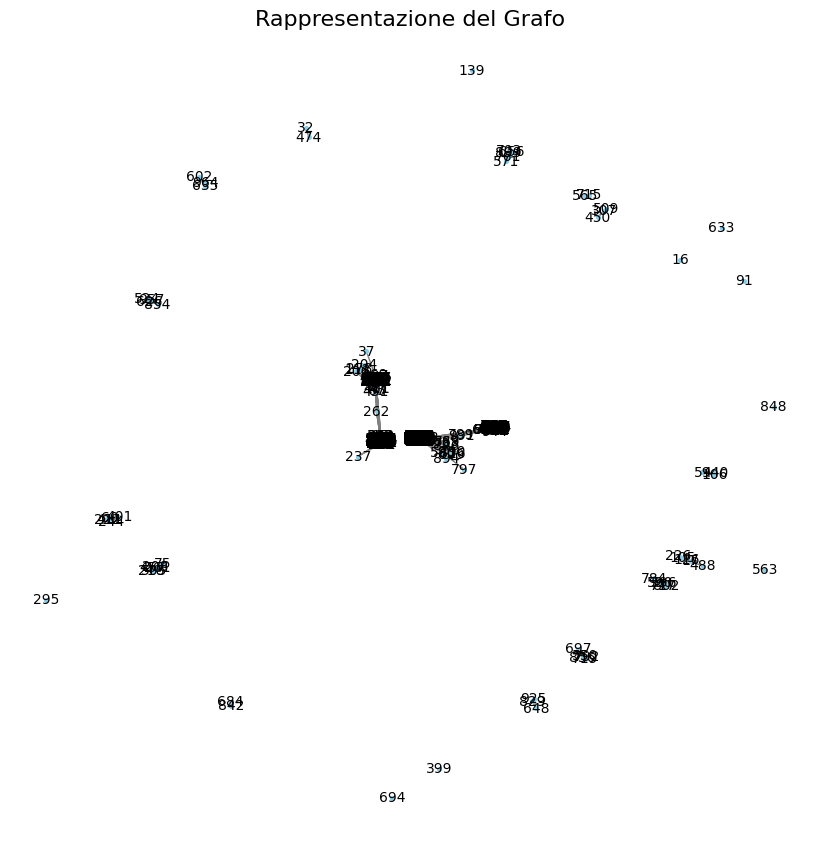

In [35]:
# Chiamata alla funzione
plot_graph_from_adjacency_matrix(best_val_adj_matrix)


Visualizzazione dei soli nodi connessi

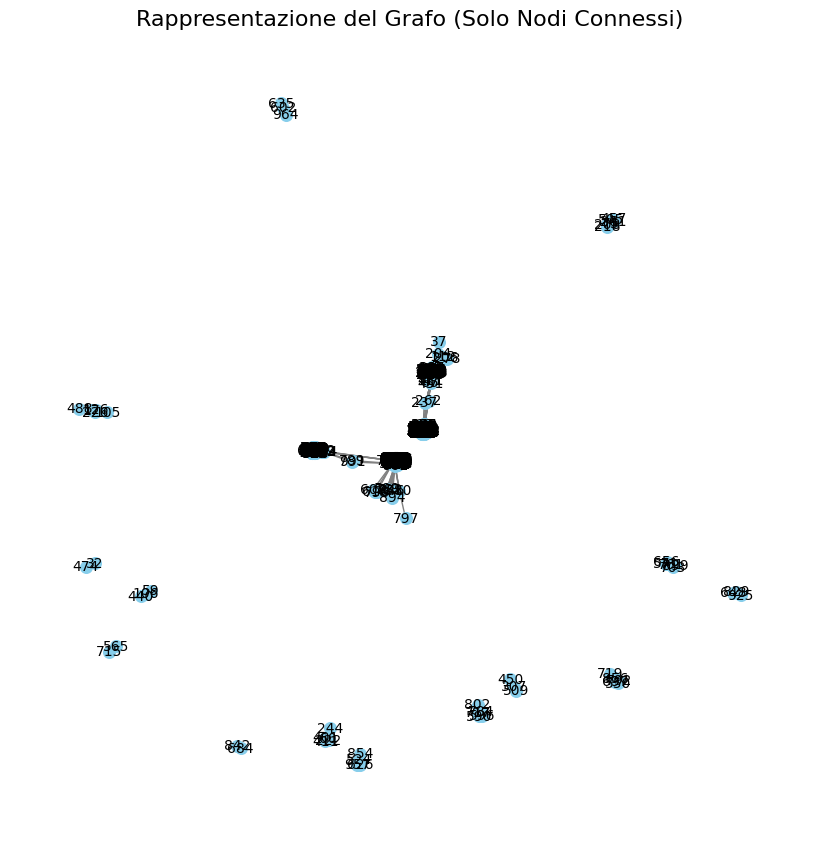

In [36]:
# Chiamata alla funzione con una matrice di esempio
plot_graph_with_connected_nodes(best_val_adj_matrix)

Stampa delle informazioni ottenute dal training, cioè:
- Connessioni correttamente rilevate:
- Nuovi nodi connessi

In [32]:
for i in range(len(val_indices)):
    for j in range(len(val_indices)):
        if i!= j:
            # Ottiene gli ID dei nodi dalla matrice val_adj_node_id_matrix (la matrice delle coppie di nodi)
            node_i_id, node_j_id = val_adj_node_id_matrix[i, j].tolist()
            # Verifica se la connessione è presente nella matrice di adiacenza predetta, ma non in quella di riferimento
            if best_val_adj_matrix[i, j] == 1 and val_adj_matrix[i, j] == 1:
                # Recupera i dati associati ai nodi
                node_i_data = G.nodes[node_i_id]
                node_j_data = G.nodes[node_j_id]
                # Estrae le informazioni relative ai nodi
                tags_i = node_i_data['tags']
                tags_j = node_j_data['tags']
                followers_i = node_i_data['followersCount']
                followers_j = node_j_data['followersCount']
                friends_i = len(node_i_data['friends'])
                friends_j = len(node_j_data['friends'])
                lang_i = node_i_data['lang']
                lang_j = node_j_data['lang']
                #Stampa le informazioni sui nuovi nodi connessi
                print(f"Connessione correttamente rilevata: {node_i_id} e {node_j_id}")
                print(f"Tags: {tags_i} - {tags_j}")
                print(f"Followers: {followers_i} vs {followers_j}")
                print(f"Friends: {friends_i} vs {friends_j}")
                print(f"Linguaggi: {lang_i} vs {lang_j}")
                print([i,j])
                print()
            elif i!= j and best_val_adj_matrix[i, j] == 1 and val_adj_matrix[i, j] == 0:
                node_i_id, node_j_id = val_adj_node_id_matrix[i, j].tolist()
                # Recupera i dati associati ai nodi
                node_i_data = G.nodes[node_i_id]
                node_j_data = G.nodes[node_j_id]
                # Estrae le informazioni relative ai nodi
                tags_i = node_i_data['tags']
                tags_j = node_j_data['tags']
                followers_i = node_i_data['followersCount']
                followers_j = node_j_data['followersCount']
                friends_i = len(node_i_data['friends'])
                friends_j = len(node_j_data['friends'])
                lang_i = node_i_data['lang']
                lang_j = node_j_data['lang']
                # Stampa le informazioni sui nuovi nodi connessi
                print(f"Nuovi nodi connessi: {node_i_id} e {node_j_id}")
                print(f"Tags: {tags_i} - {tags_j}")
                print(f"Followers: {followers_i} vs {followers_j}")
                print(f"Friends: {friends_i} vs {friends_j}")
                print(f"Linguaggi: {lang_i} vs {lang_j}")
                print([i,j])
                print()


Output streaming troncato alle ultime 5000 righe.
263939125
Nuovi nodi connessi: 263939125 e 1323969440
Tags: [ "#nationaldogday" ] - [ "#nationaldogday" ]
Followers: 10054 vs 2717
Friends: 932 vs 698
Linguaggi: "en" vs "en"
[998, 738]

263939125
Nuovi nodi connessi: 263939125 e 1895793475
Tags: [ "#nationaldogday" ] - [ "#nationaldogday" ]
Followers: 10054 vs 207
Friends: 932 vs 6
Linguaggi: "en" vs "en"
[998, 739]

263939125
Nuovi nodi connessi: 263939125 e 1723469144
Tags: [ "#nationaldogday" ] - [ "#nationaldogday" ]
Followers: 10054 vs 822
Friends: 932 vs 658
Linguaggi: "en" vs "en"
[998, 741]

263939125
Nuovi nodi connessi: 263939125 e 160094068
Tags: [ "#nationaldogday" ] - [ "#nationaldogday" ]
Followers: 10054 vs 660
Friends: 932 vs 2116
Linguaggi: "en" vs "en"
[998, 742]

263939125
Nuovi nodi connessi: 263939125 e 3304795922
Tags: [ "#nationaldogday" ] - [ "#nationaldogday" ]
Followers: 10054 vs 364
Friends: 932 vs 656
Linguaggi: "en" vs "en"
[998, 743]

263939125
Nuovi nodi 